In [1]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap


import warnings
warnings.filterwarnings("ignore")

features_sc_names = [
        'SCR_Amplitude_mean',
        'SCR_Amplitude_std',
        'SCR_RiseTime_mean',
        'SCR_RiseTime_std',
        'SCR_RecoveryTime_mean',
        'SCR_RecoveryTime_std'
        ] 

features_bvp_names = None

In [2]:
def extract_sc(signal):
    df, info = nk.eda_process(signal, sampling_rate=31)

    features_sc = np.array([
        np.nanmean(info['SCR_Amplitude']),
        np.nanstd(info['SCR_Amplitude']),
        np.nanmean(info['SCR_RiseTime']),
        np.nanstd(info['SCR_RiseTime']),
        np.nanmean(info['SCR_RecoveryTime']),
        np.nanstd(info['SCR_RecoveryTime'])
        ])
    
    return features_sc

def extract_bvp(signal):
    global features_bvp_names
    df, info = nk.ppg_process(signal, sampling_rate=31)
    feature_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
    if features_bvp_names == None:
        features_bvp_names = list(feature_bvp)
        
    feature_bvp = feature_bvp[features_bvp_names]
        
    return feature_bvp.to_numpy()[0]

## Data Processing
In this section, we will import the "mazeball" dataset with the `pandas` library. 

In [3]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']

In [4]:
mb_data.shape

(36, 3)

In [5]:
alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],
    
    # games
    'game_variant': [],
    'gameplay_score': [], 
    'keystrokes': [], # keystrokes per second
    'keystrokes_mean': [],
    'keystrokes_std': [],
    'keystrokes_min': [], 
    'keystrokes_max': [],

    # physiological features
    'features_sc': [],
    'features_bvp': [],
    
    'class': [], # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
    }

def extract_all_data(data_dict, effect = 'challenge'):
    for a in tqdm(range(36)): # player number
        player_demographics = p_demo[a] # player demographics
        player_game = p_games[a]
        player_tutorial = p_tutorial[a]
        
        for b in range(len(player_game)): # game number
            game_pref = p_games[a][b]['preferences']
            game_a = p_games[a][b]['data']['A'][0]
            game_b = p_games[a][b]['data']['B']
            game_keystroke_a = p_games[a][b]['data']['A'][0]['keystrokes']
            game_keystroke_b = p_games[a][b]['data']['B']['keystrokes']
            
            features_sc_a = extract_sc(game_a['physio']['SC'])
            features_bvp_a = extract_bvp(game_a['physio']['BVP'])
            
            features_sc_b = extract_sc(game_b['physio']['SC'])
            features_bvp_b = extract_bvp(game_b['physio']['BVP'])
            
            # append information for Game A
            alldata['player_id'] += [player_demographics['player_id']]
            alldata['player_age'] += [player_demographics['age']]
            alldata['player_gender'] += [player_demographics['male']]
            alldata['player_playgames'] += [player_demographics['playgames']]
            alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]
            
            alldata['game_variant'] += [game_a['variant']]
            alldata['gameplay_score'] += [game_a['gameplay']['score'][-1]] # the last element in score array is the final score
            
            alldata['features_sc'] += [features_sc_a]
            alldata['features_bvp'] += [features_bvp_a]
            # calculate keystrokes per second and append information into alldata
            num_keystroke_a = 0
            for i in game_keystroke_a:
                if i == "time":
                    break
                num_keystroke_a += sum(game_keystroke_a[i])
            kps_a = num_keystroke_a / game_keystroke_a['time'][-1]
            alldata['keystrokes'] += [kps_a]
            alldata['keystrokes_mean'] += [np.mean(game_keystroke_a['time'])]
            alldata['keystrokes_std'] += [np.std(game_keystroke_a['time'])]
            alldata['keystrokes_min'] += [np.min(game_keystroke_a['time'])]
            alldata['keystrokes_max'] += [np.max(game_keystroke_a['time'])]
            
            # append information for Game B
            alldata['player_id'] += [player_demographics['player_id']]
            alldata['player_age'] += [player_demographics['age']]
            alldata['player_gender'] += [player_demographics['male']]
            alldata['player_playgames'] += [player_demographics['playgames']]
            alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]
            
            alldata['game_variant'] += [game_b['variant']]
            alldata['gameplay_score'] += [game_b['gameplay']['score'][-1]] # the last element in score array is the final score
            
            alldata['features_sc'] += [features_sc_b]
            alldata['features_bvp'] += [features_bvp_b]
            
            # calculate keystrokes per second and append information into alldata
            num_keystroke_b = 0
            for i in game_keystroke_b:
                if i == "time":
                    break
                num_keystroke_b += sum(game_keystroke_b[i])
            kps_b = num_keystroke_b / game_keystroke_b['time'][-1]
            alldata['keystrokes'] += [kps_b]
            alldata['keystrokes_mean'] += [np.mean(game_keystroke_b['time'])]
            alldata['keystrokes_std'] += [np.std(game_keystroke_b['time'])]
            alldata['keystrokes_min'] += [np.min(game_keystroke_b['time'])]
            alldata['keystrokes_max'] += [np.max(game_keystroke_b['time'])]
            
            if game_pref[effect] == "A": # if game A is more intense than game B
                alldata['class'] += [1] # class label for Game A
                alldata['class'] += [0] # class label for Game B
            
            elif game_pref[effect] == "B": # if game B is more intense
                alldata['class'] += [0]
                alldata['class'] += [1]
            
            elif game_pref[effect] == "Both equally":
                alldata['class'] += [1]
                alldata['class'] += [1]
            
            elif game_pref[effect] == "Neither":
                alldata['class'] += [0]
                alldata['class'] += [0]

extract_all_data(effect = 'relaxation', data_dict = alldata)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:53<00:00,  1.48s/it]


### Preparation for training
The cell below will create the dataset with the `X` as the training data which consists of:
1. player_age
2. gender
3. player_playgames
4. player_playfrequency
5. game_variant
6. SC (Skin Inductance)
7. BVP (Blood Pressure Pulse)

and `Y` for having the class that we had specify at the cell before.

In [68]:
# create dataset
X = [] # training data
Y = [] # class label
Z = [] # player id for cross-validation
for i in range(len(alldata['class'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                  alldata['player_gender'][i],
                  alldata['player_playgames'][i],
                  alldata['player_playfrequency'][i],
                  alldata['game_variant'][i],
                  alldata['gameplay_score'][i],
                  alldata['keystrokes'][i],
                  alldata['keystrokes_mean'][i],
                  alldata['keystrokes_std'][i],
                  alldata['keystrokes_min'][i],
                  alldata['keystrokes_max'][i]]),
                  alldata['features_sc'][i],
                  alldata['features_bvp'][i],
                  ])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]
    
feature_names = ['player_age', 'player_gender', 'player_playgames', 'player_playfrequency', 'game_variant', 'gameplay_score', 'keystrokes', 'keystrokes_mean', 'keystrokes_std', 'keystrokes_min', 'keystrokes_max']
feature_names += features_sc_names
feature_names += features_bvp_names

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)

print(X.shape)
print(Y.shape)
print(Z.shape)

(288, 100)
(288,)
(288,)


In [69]:
X = np.nan_to_num(X, neginf=0, posinf=0)
print(np.any(np.isnan(X)))
print(len(feature_names))

False
100


## Model Training

In [70]:
# Supervised Learning Algorithm = Adaptive Boosting(Adaboost)
# Information: Gameplay & Keystroke information
# Preference = Challenge

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# specify your configurations as a dict
params = {
    "n_estimators": 50,
    "learning_rate": 0.05,
    "algorithm": "SAMME.R",
    "random_state": 42,
}
# divide into training and testing; 
# leave-one-person-out: X-1 persons for training, 1 person for testing
predictions = []
labels = []

for idx in tqdm(player_id):
    istrain = Z!=idx
    istest = Z==idx
    
    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]
    
    X_train = np.where(np.isnan(X_train), 0, X_train)
    X_test = np.where(np.isnan(X_test), 0, X_test)
    
    # Create an AdaBoost classifier with a decision tree as the base learner
    adaboost_clf = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        **params
    )
    
    # Train the model
    adaboost_clf.fit(X_train, Y_train)

    # test the model
    Y_pred = adaboost_clf.predict(X_test)
    
    # print('Y logits:', Y_pred)
    pred_class = (Y_pred > 0.5).astype("int")
    
    # print('Y predictions:', pred_class)
    
    predictions += [pred_class]
    labels += [Y_test]

100%|██████████| 36/36 [00:14<00:00,  2.53it/s]


In [71]:
accuracy = np.mean(np.concatenate(predictions) == np.concatenate(labels))
print(accuracy)

0.6354166666666666


In [72]:
X

array([[26.        ,  1.        ,  1.        , ...,  1.96899498,
         2.71137975,  0.90485519],
       [26.        ,  1.        ,  1.        , ...,  2.00645982,
         2.26692439,  1.17748683],
       [26.        ,  1.        ,  1.        , ...,  1.90912045,
         2.01296841,  0.70313536],
       ...,
       [25.        ,  0.        ,  1.        , ...,  1.99401756,
         3.06986268,  0.90485519],
       [25.        ,  0.        ,  1.        , ...,  2.01233661,
         2.27845258,  0.9843895 ],
       [25.        ,  0.        ,  1.        , ...,  2.01657699,
         2.50552268,  0.96273868]])

In [73]:
feature_names

['player_age',
 'player_gender',
 'player_playgames',
 'player_playfrequency',
 'game_variant',
 'gameplay_score',
 'keystrokes',
 'keystrokes_mean',
 'keystrokes_std',
 'keystrokes_min',
 'keystrokes_max',
 'SCR_Amplitude_mean',
 'SCR_Amplitude_std',
 'SCR_RiseTime_mean',
 'SCR_RiseTime_std',
 'SCR_RecoveryTime_mean',
 'SCR_RecoveryTime_std',
 'PPG_Rate_Mean',
 'HRV_MeanNN',
 'HRV_SDNN',
 'HRV_SDANN1',
 'HRV_SDNNI1',
 'HRV_SDANN2',
 'HRV_SDNNI2',
 'HRV_SDANN5',
 'HRV_SDNNI5',
 'HRV_RMSSD',
 'HRV_SDSD',
 'HRV_CVNN',
 'HRV_CVSD',
 'HRV_MedianNN',
 'HRV_MadNN',
 'HRV_MCVNN',
 'HRV_IQRNN',
 'HRV_SDRMSSD',
 'HRV_Prc20NN',
 'HRV_Prc80NN',
 'HRV_pNN50',
 'HRV_pNN20',
 'HRV_MinNN',
 'HRV_MaxNN',
 'HRV_HTI',
 'HRV_TINN',
 'HRV_ULF',
 'HRV_VLF',
 'HRV_LF',
 'HRV_HF',
 'HRV_VHF',
 'HRV_TP',
 'HRV_LFHF',
 'HRV_LFn',
 'HRV_HFn',
 'HRV_LnHF',
 'HRV_SD1',
 'HRV_SD2',
 'HRV_SD1SD2',
 'HRV_S',
 'HRV_CSI',
 'HRV_CVI',
 'HRV_CSI_Modified',
 'HRV_PIP',
 'HRV_IALS',
 'HRV_PSS',
 'HRV_PAS',
 'HRV_GI',
 'HR

In [80]:
# Sample data to create background dataset
background_data = shap.sample(X, 100)

# Create a SHAP explainer using the KernelExplainer
model_explainable = shap.KernelExplainer(adaboost_clf.predict, data=background_data)

# Compute SHAP values for the input data
shap_values = model_explainable.shap_values(X)

  0%|          | 0/288 [00:00<?, ?it/s]100%|██████████| 288/288 [21:05<00:00,  4.39s/it]


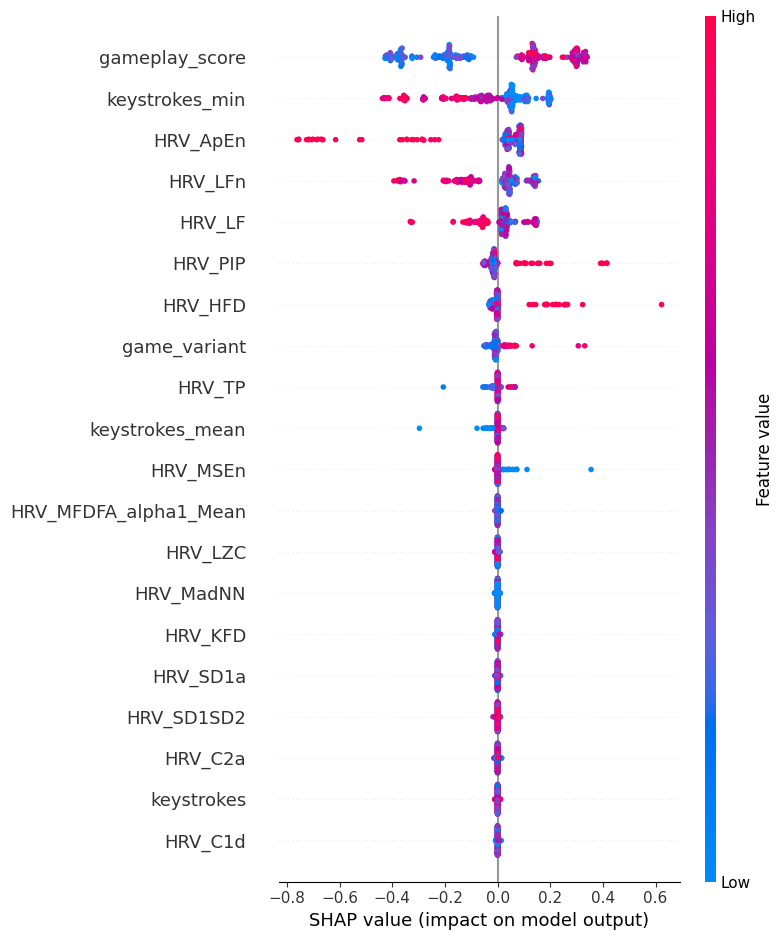

In [81]:
shap.summary_plot(shap_values, features=X, feature_names=feature_names)

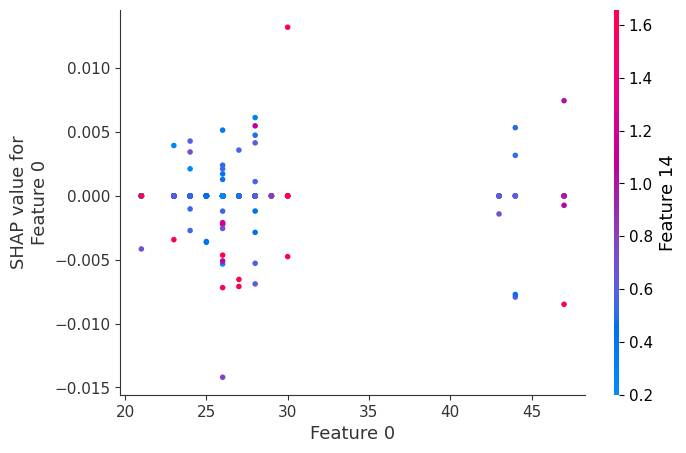

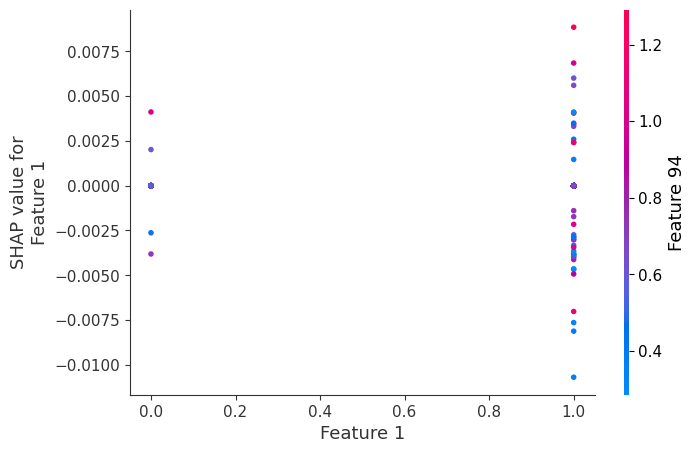

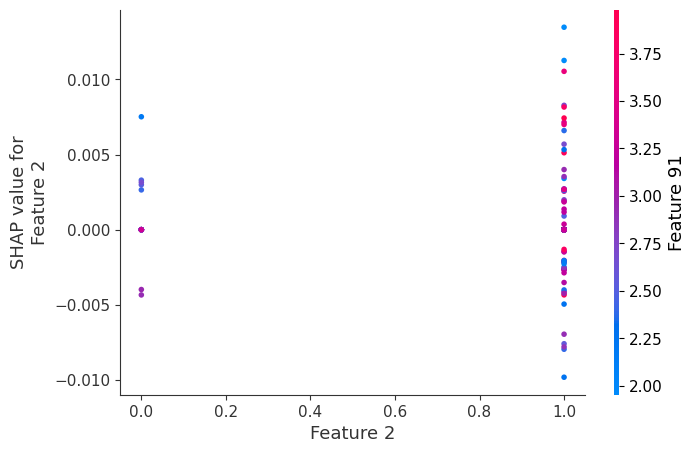

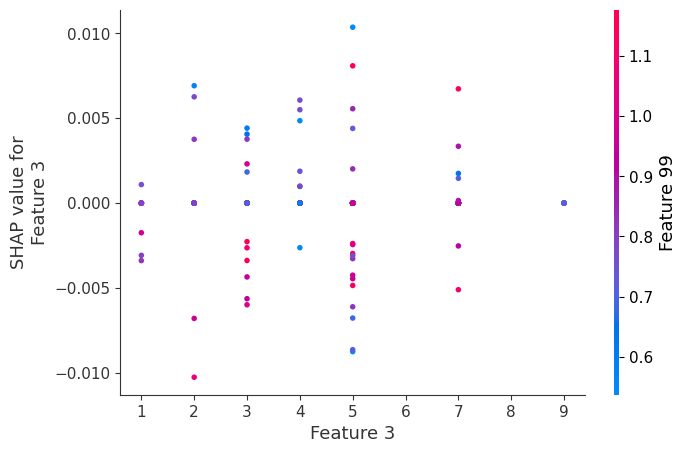

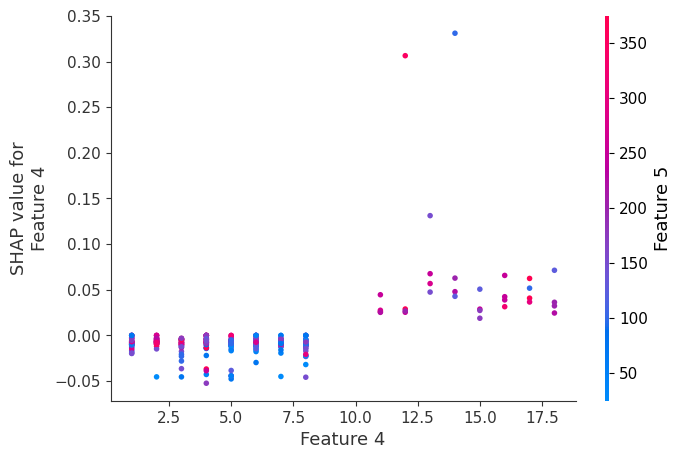

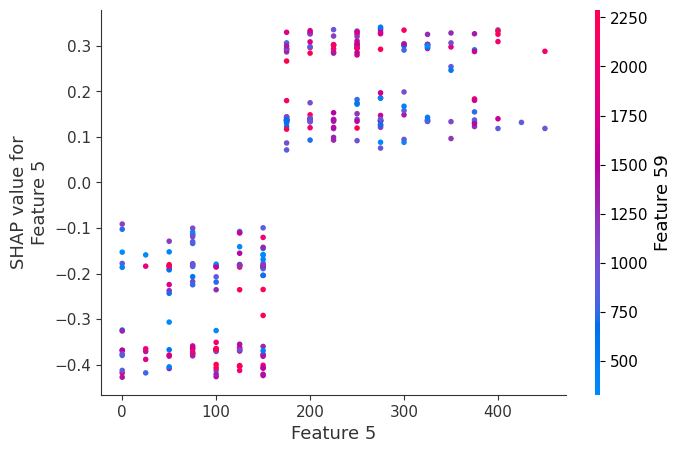

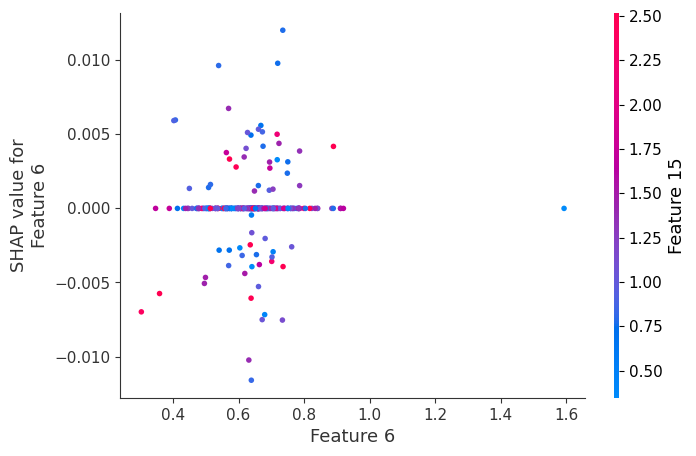

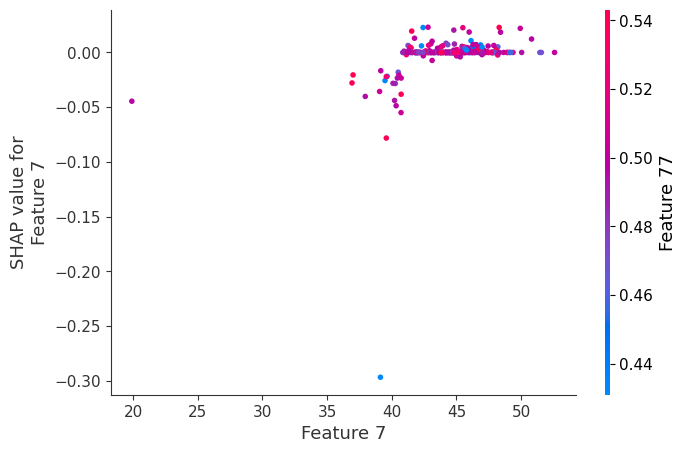

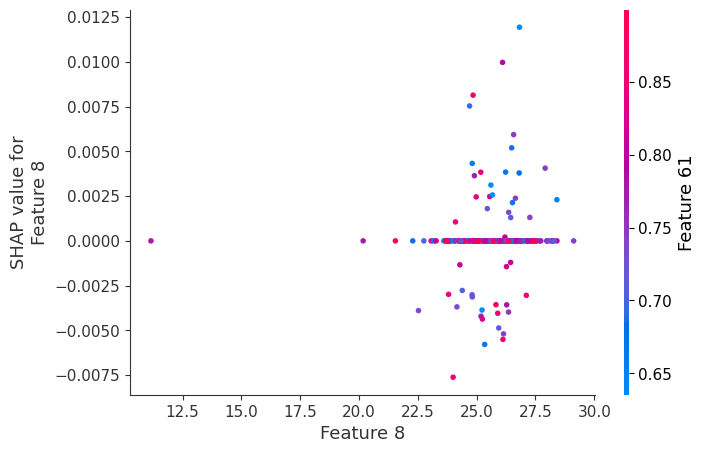

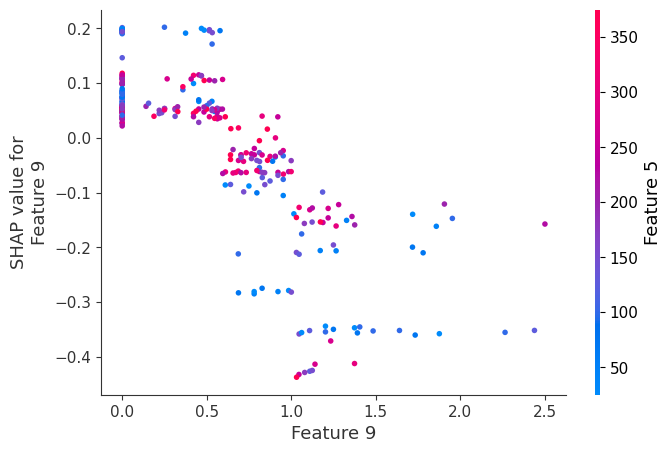

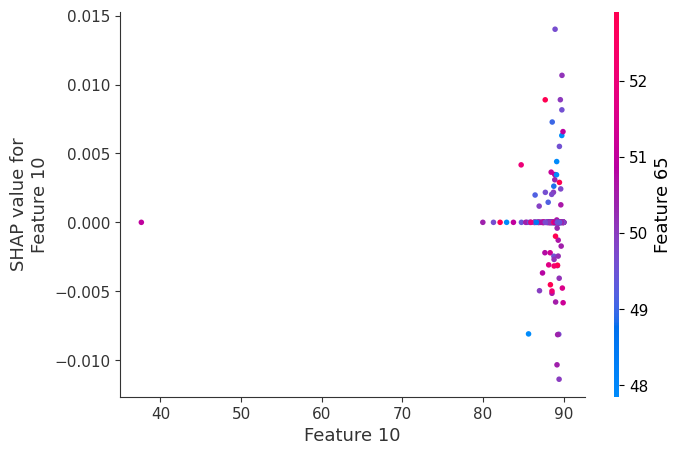

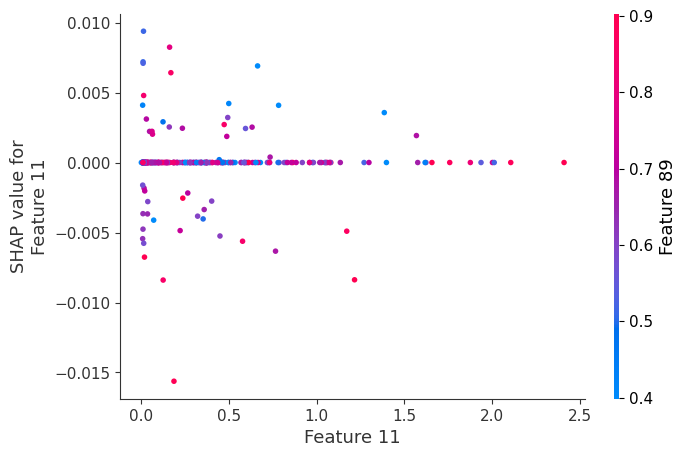

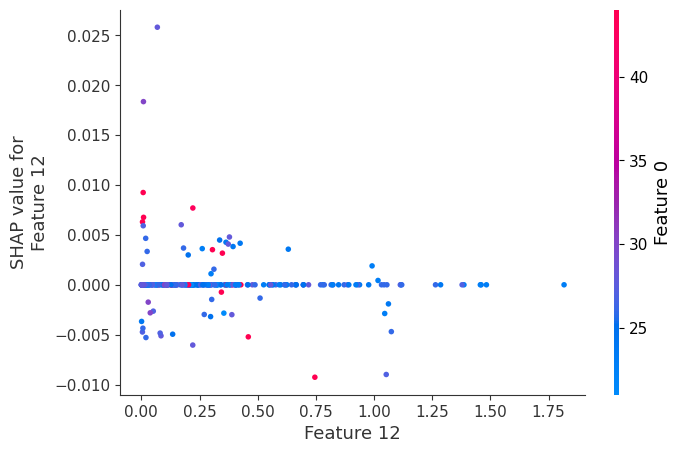

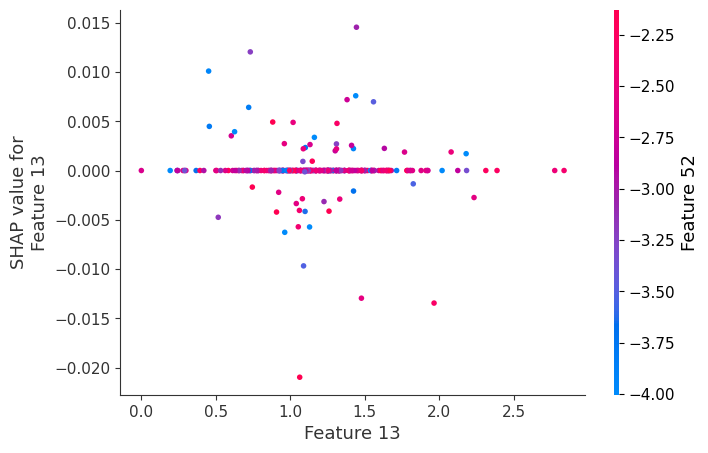

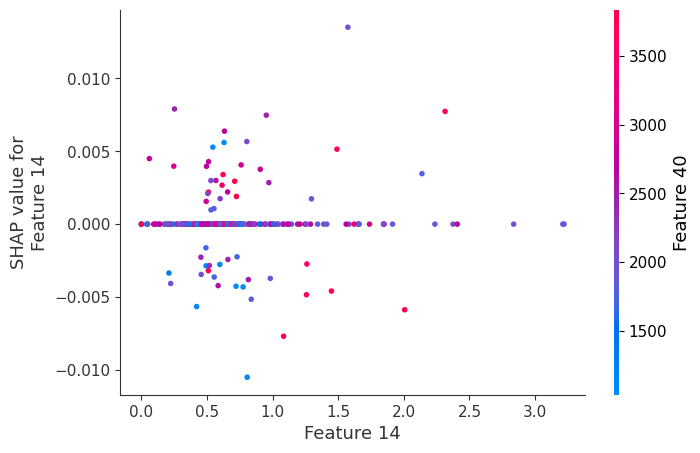

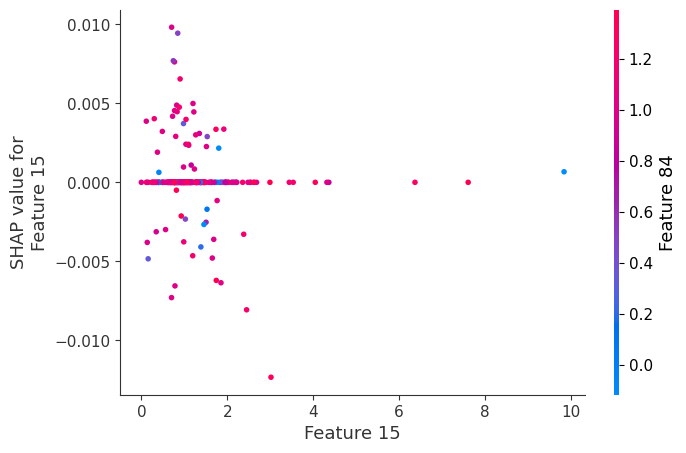

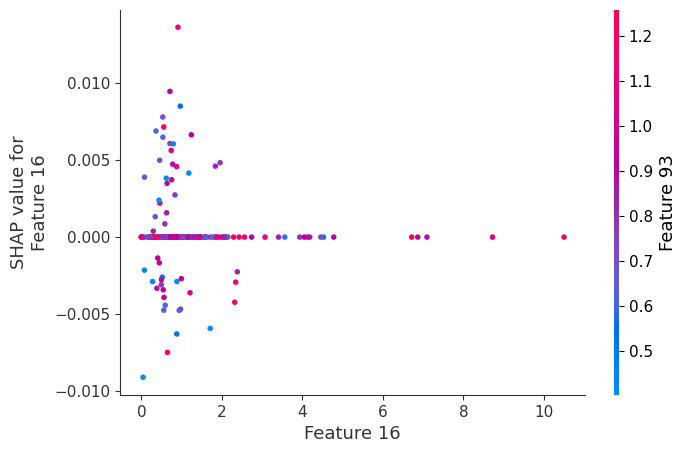

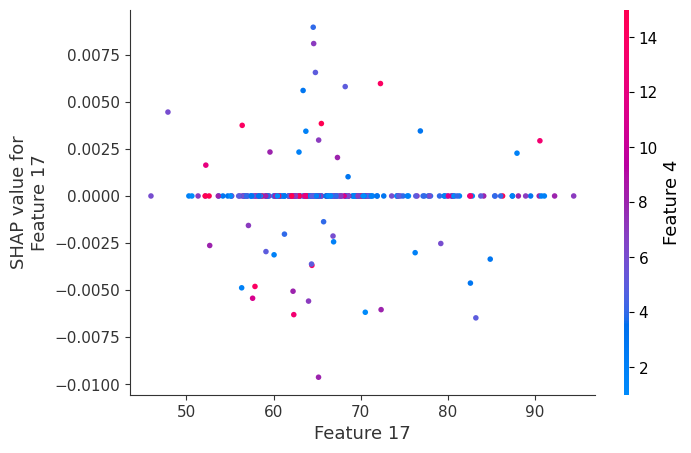

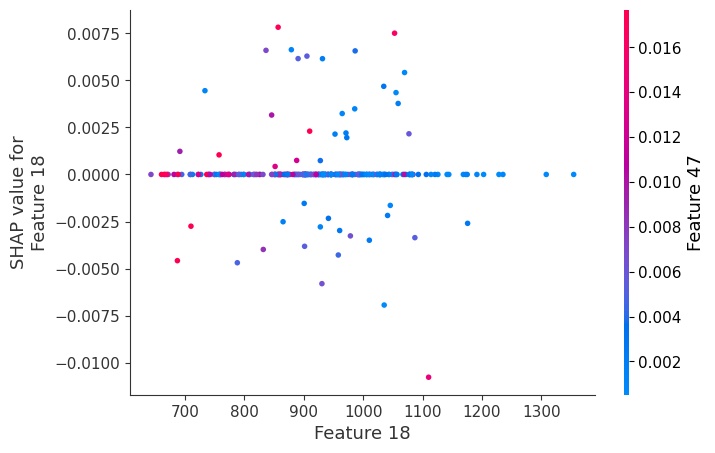

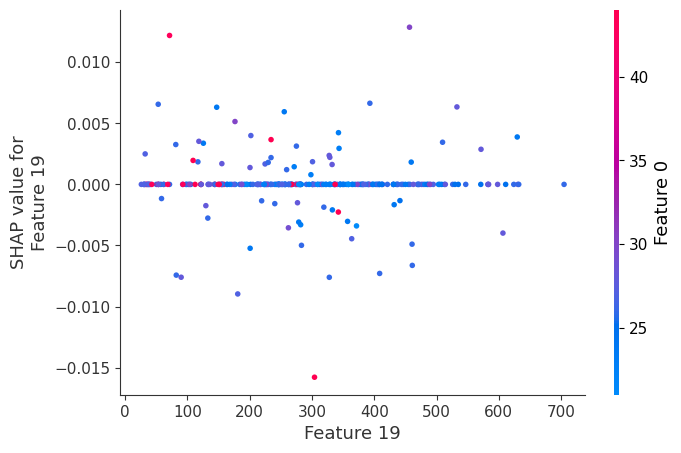

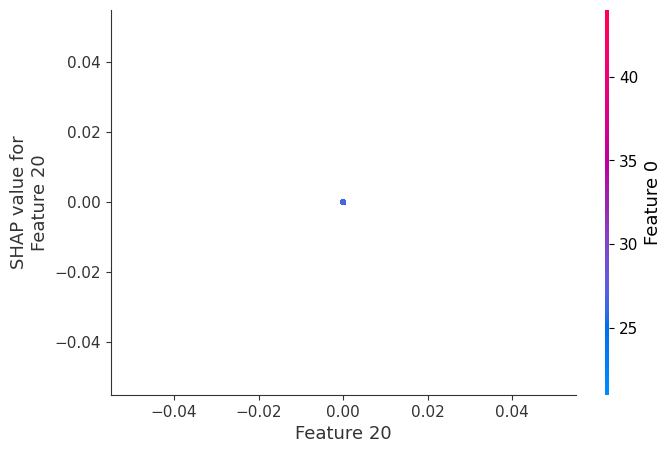

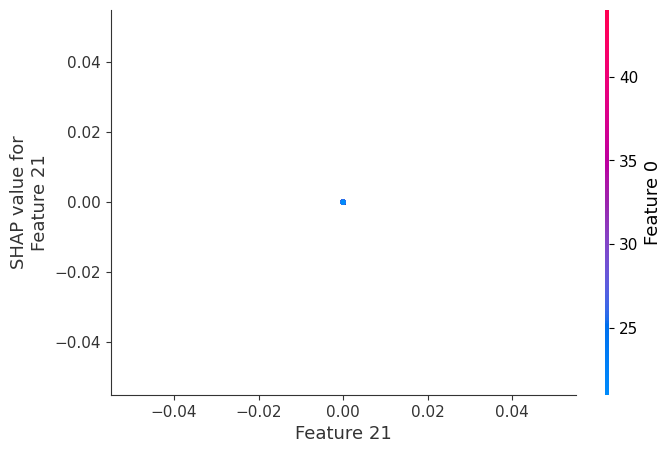

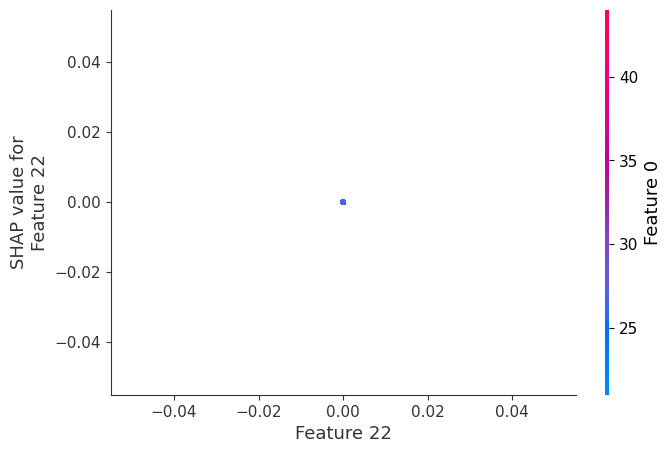

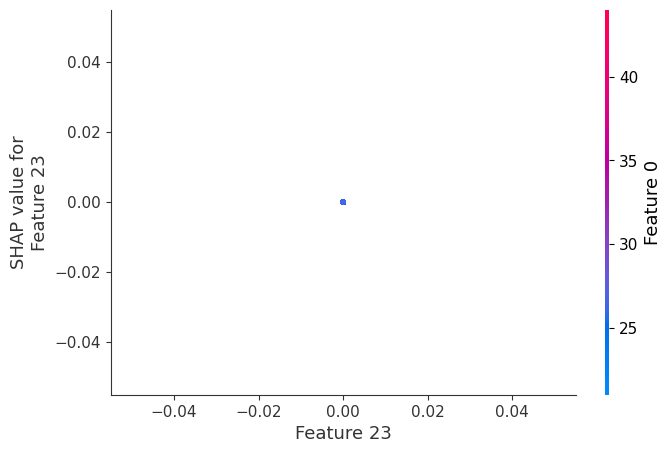

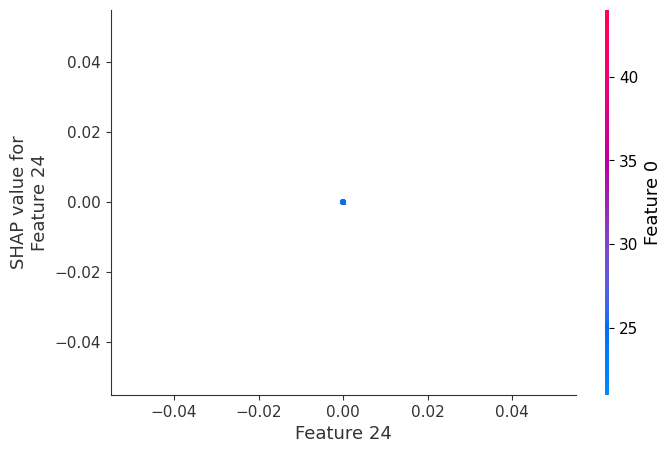

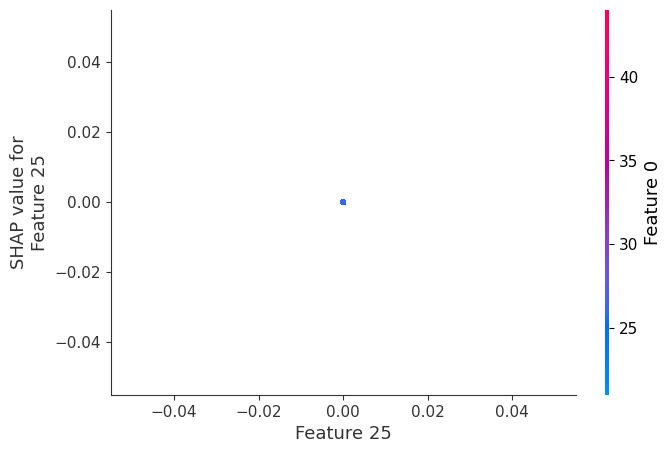

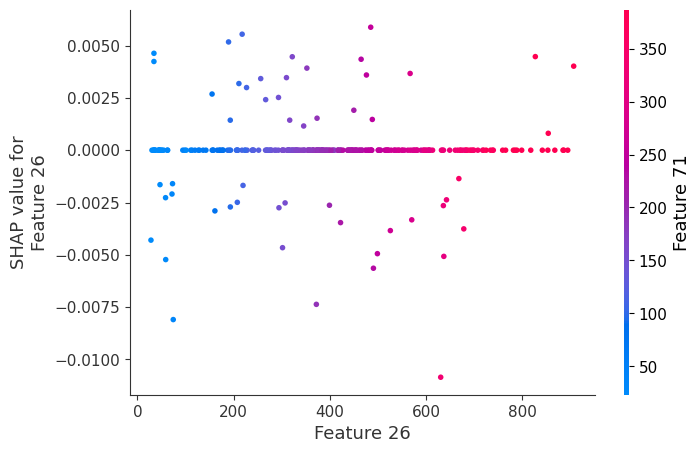

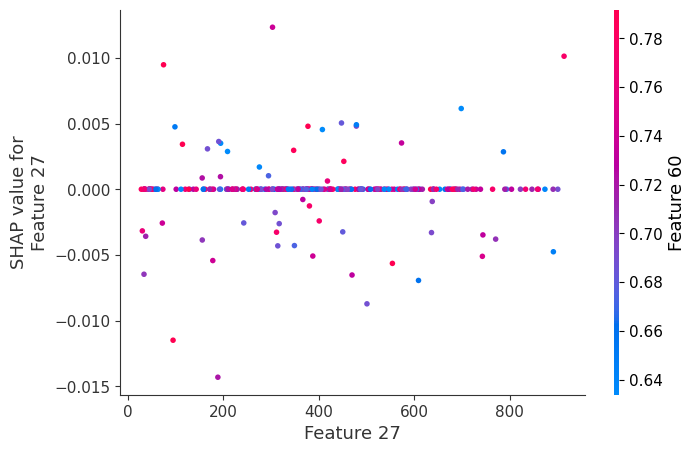

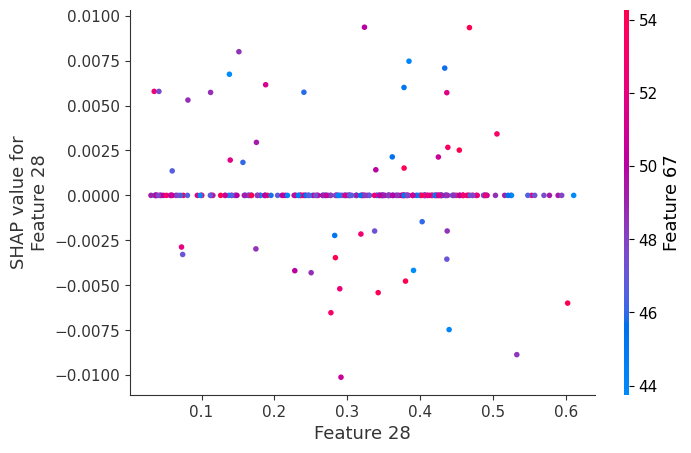

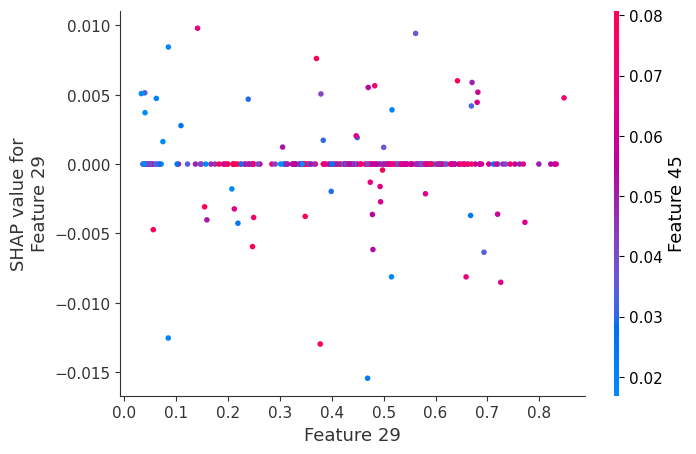

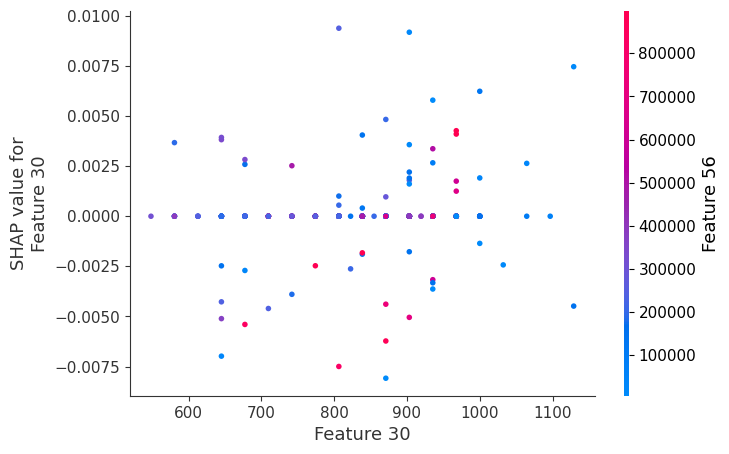

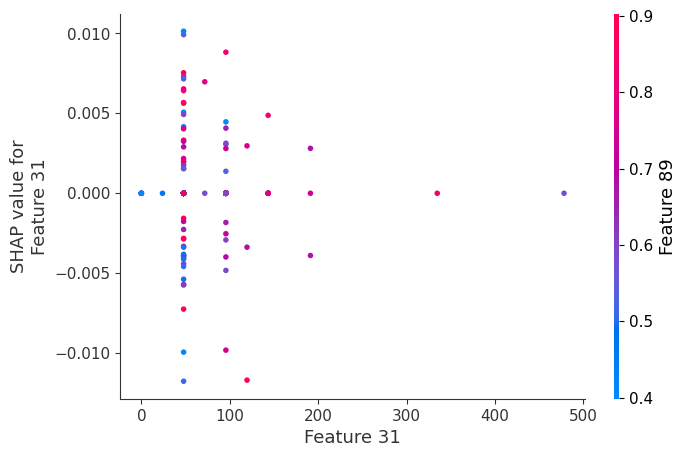

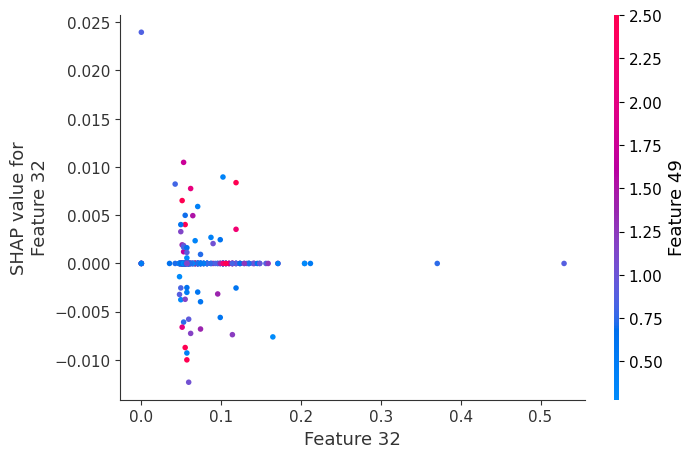

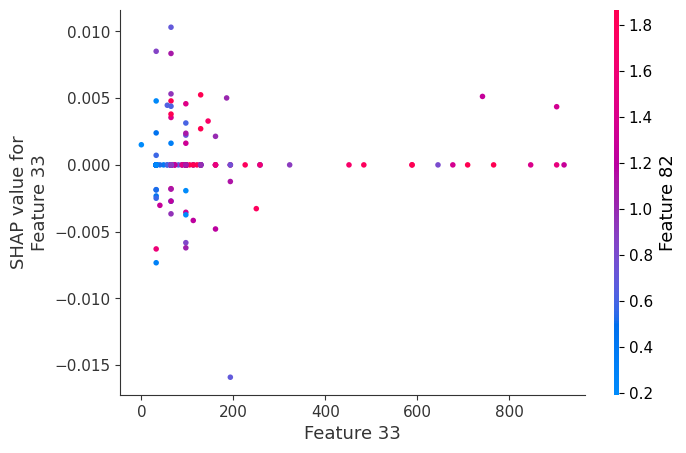

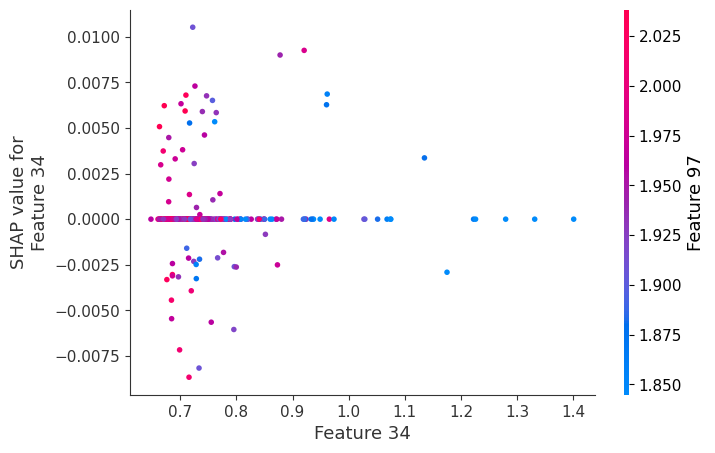

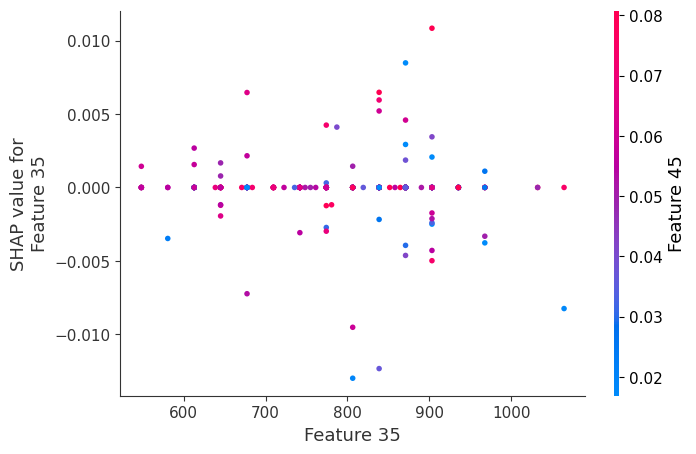

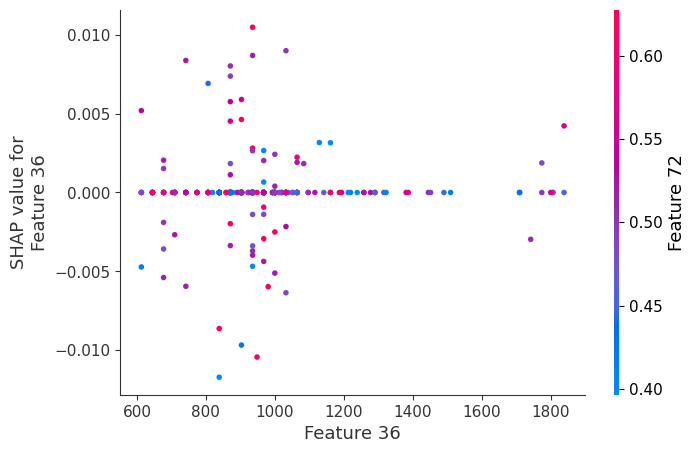

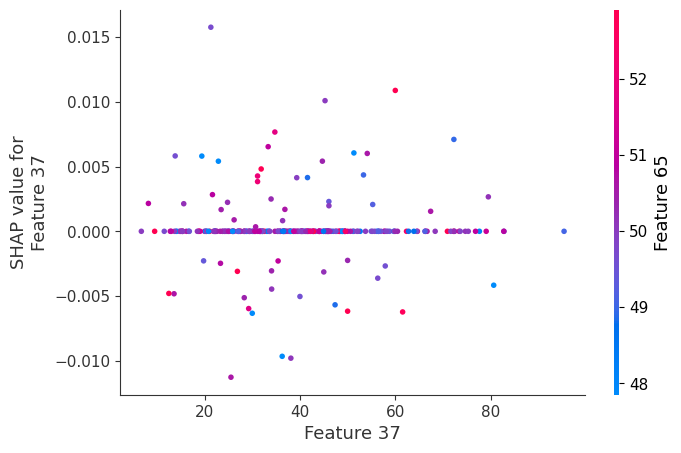

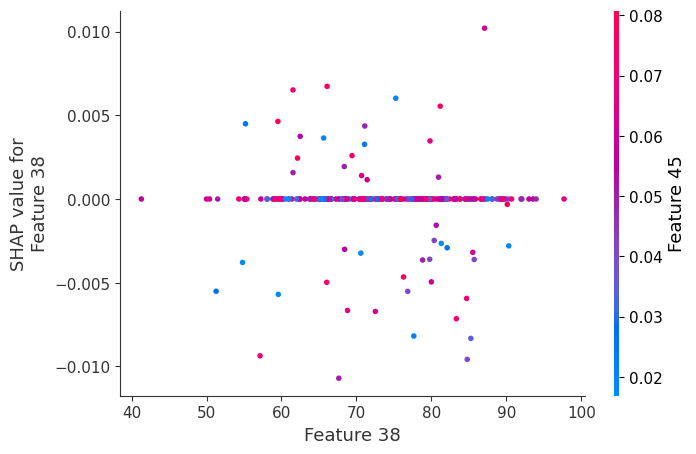

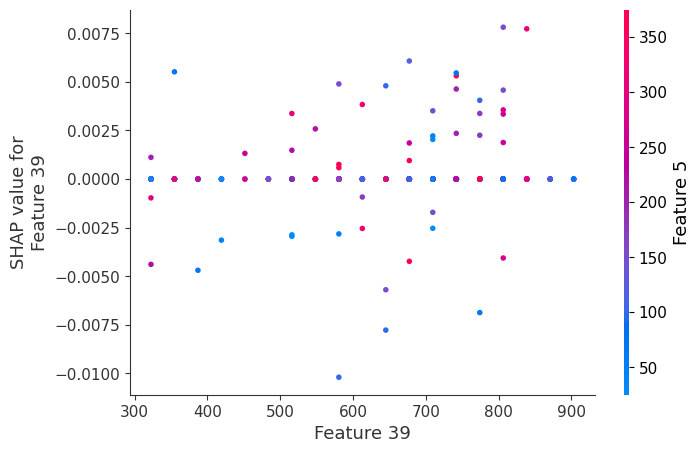

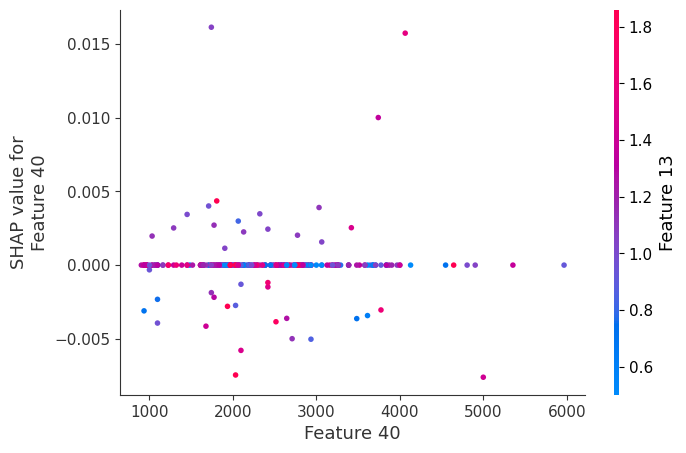

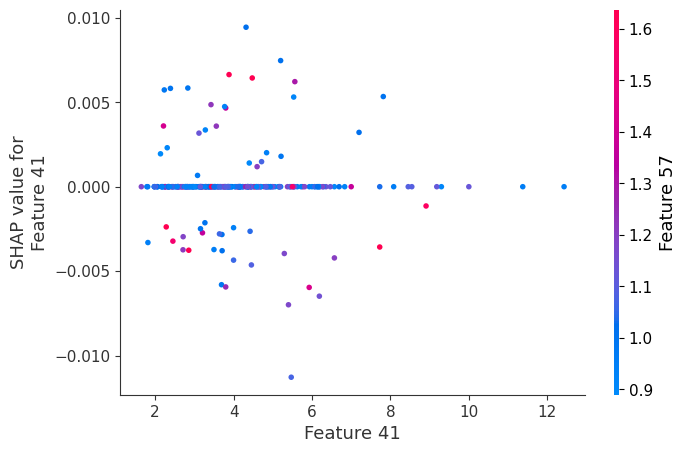

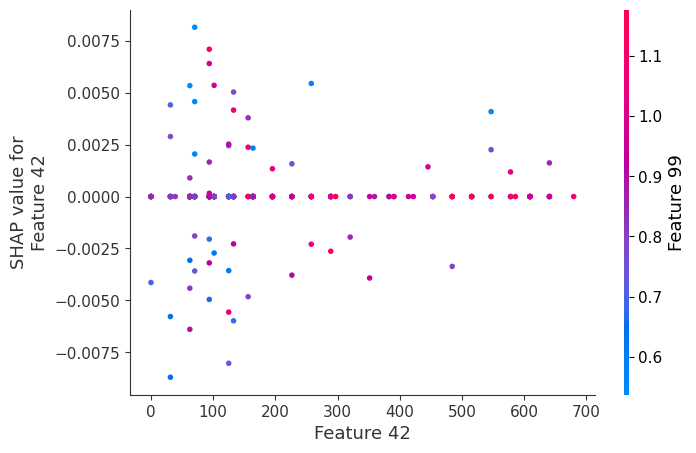

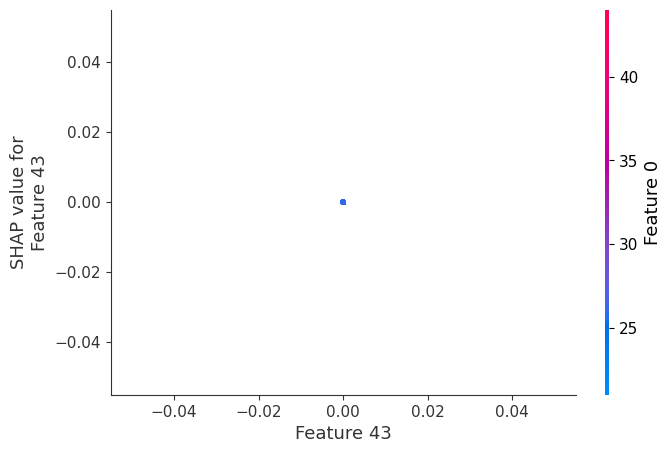

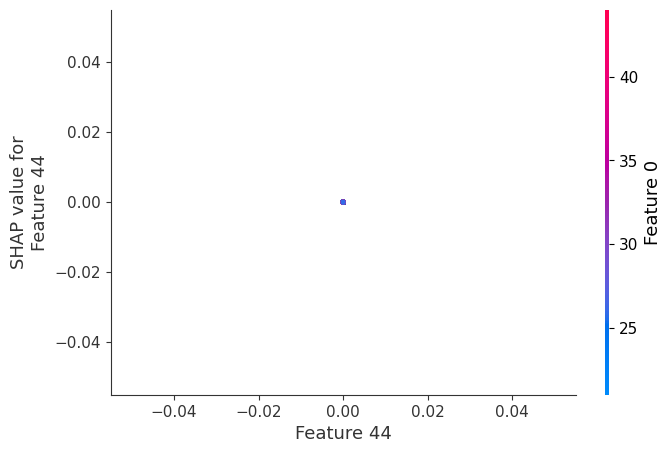

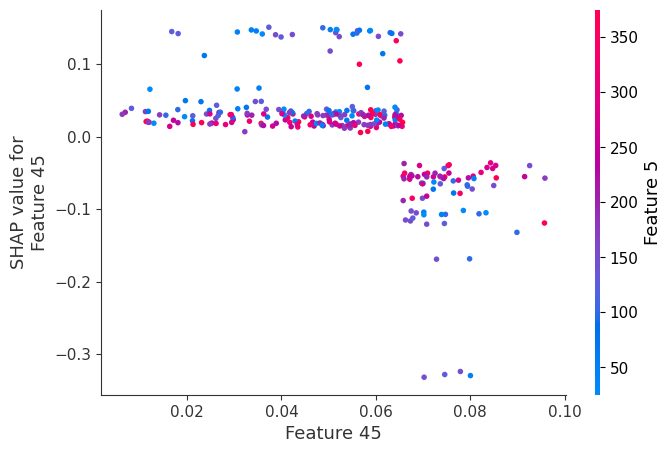

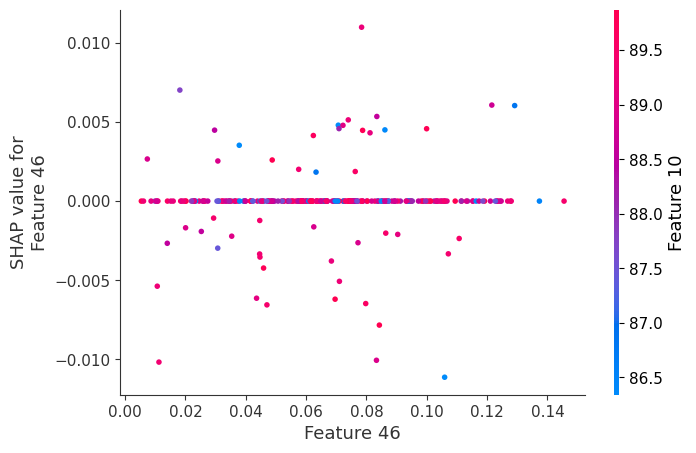

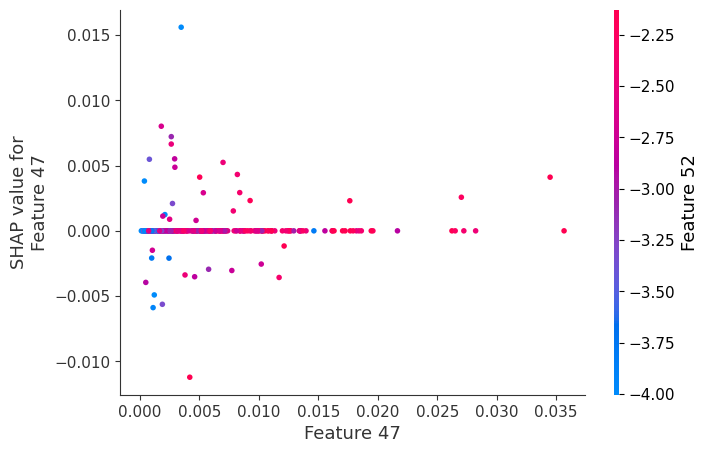

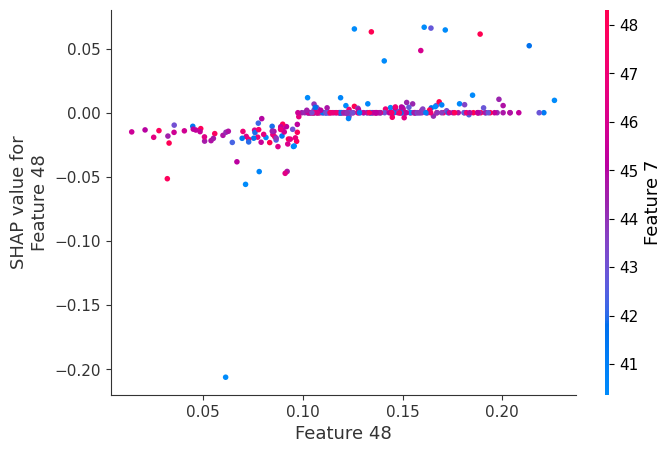

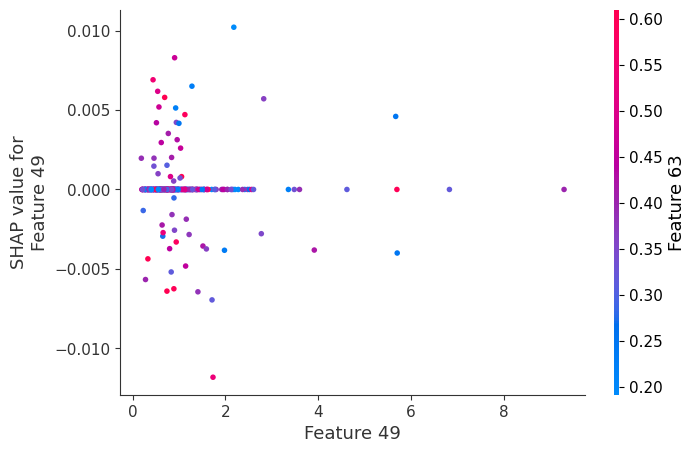

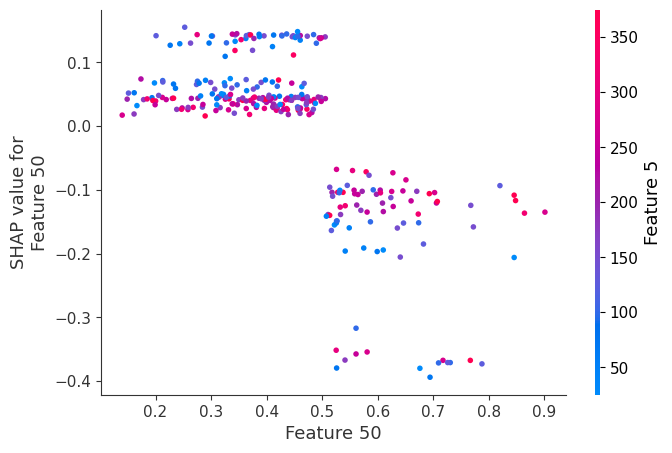

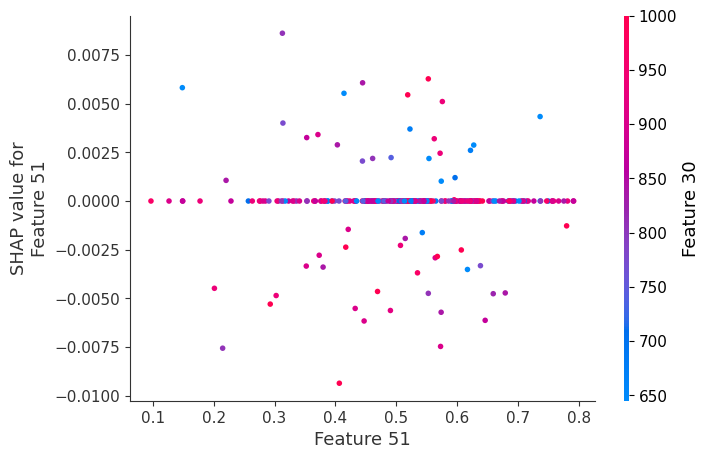

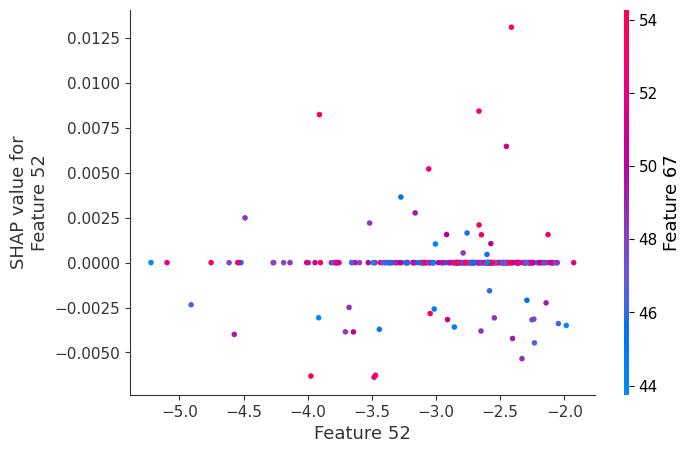

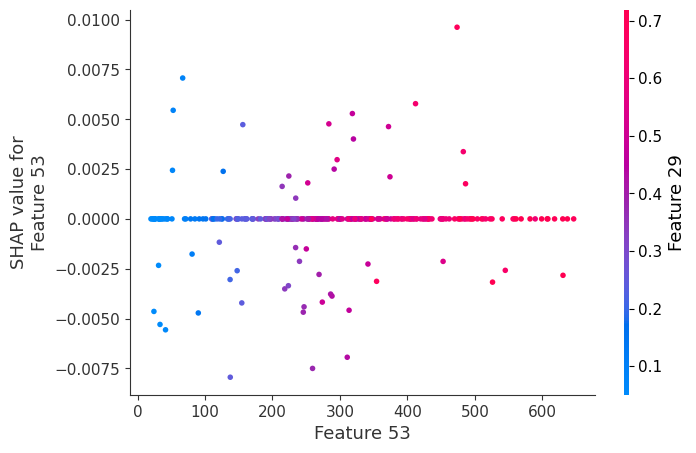

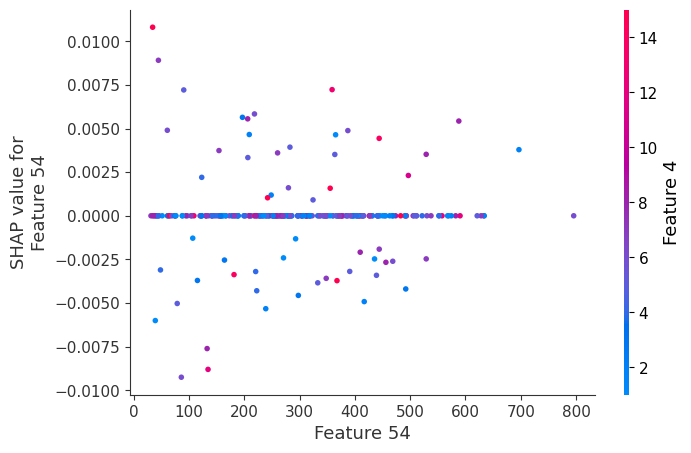

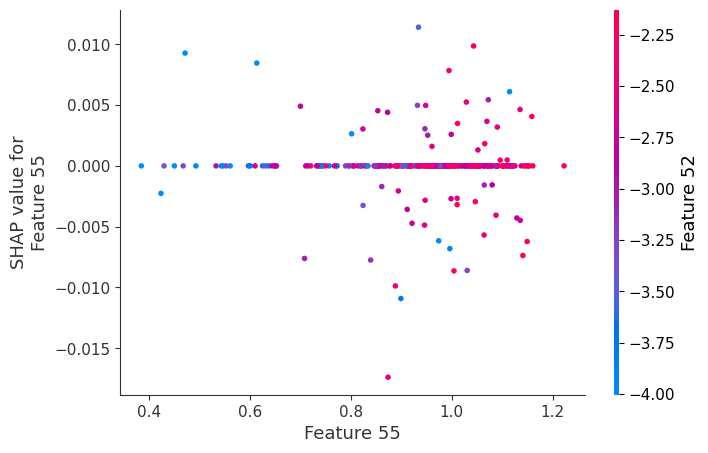

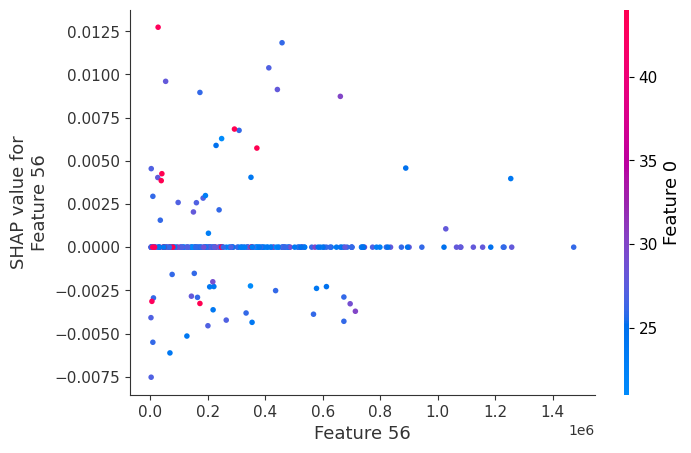

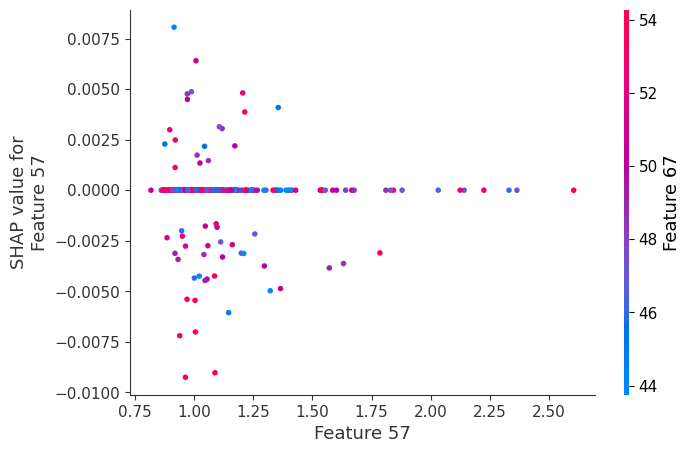

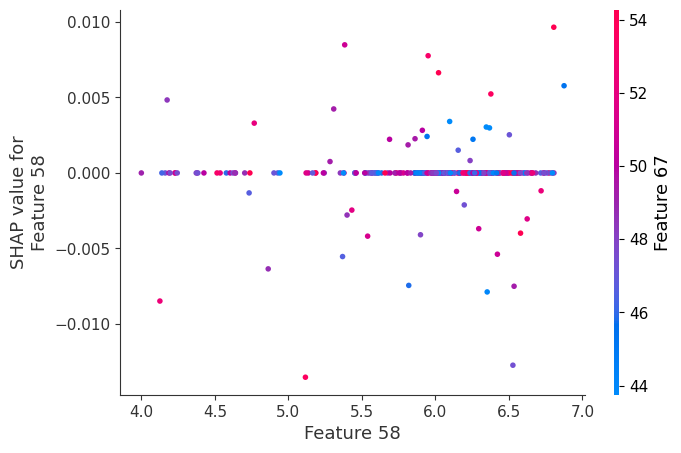

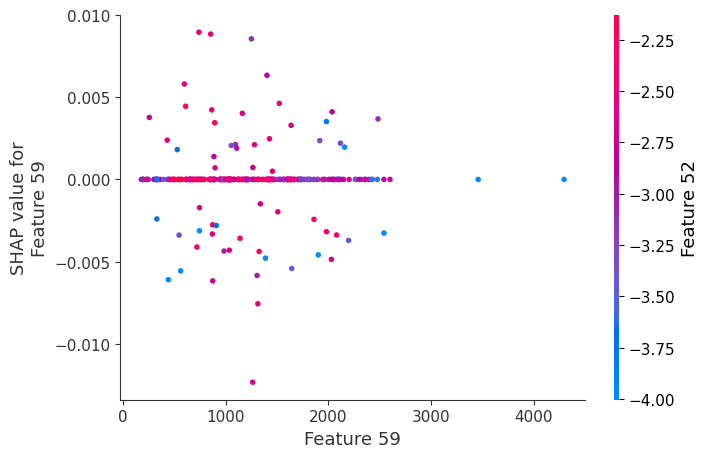

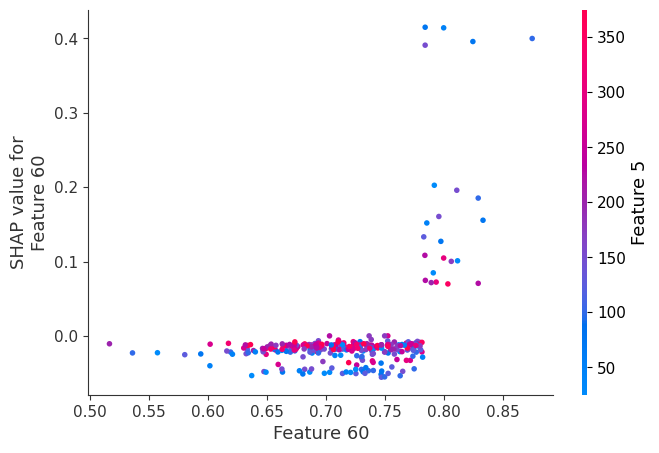

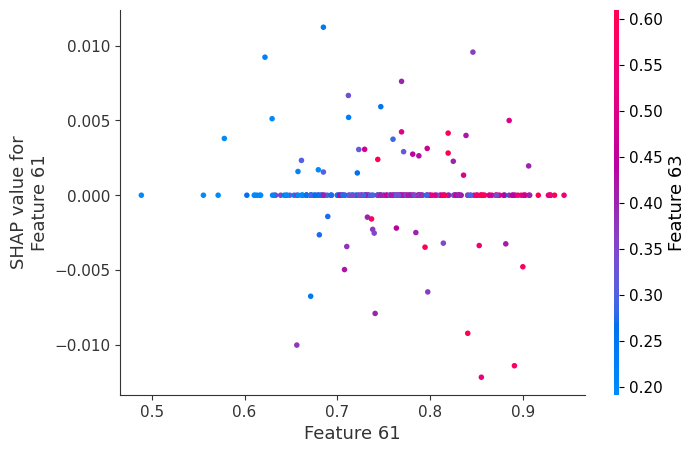

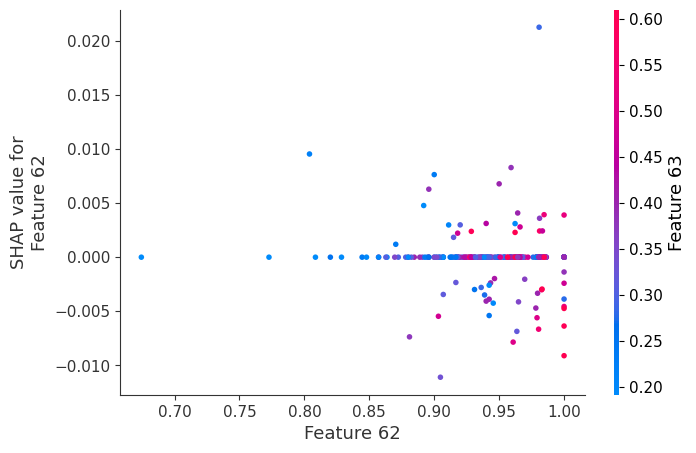

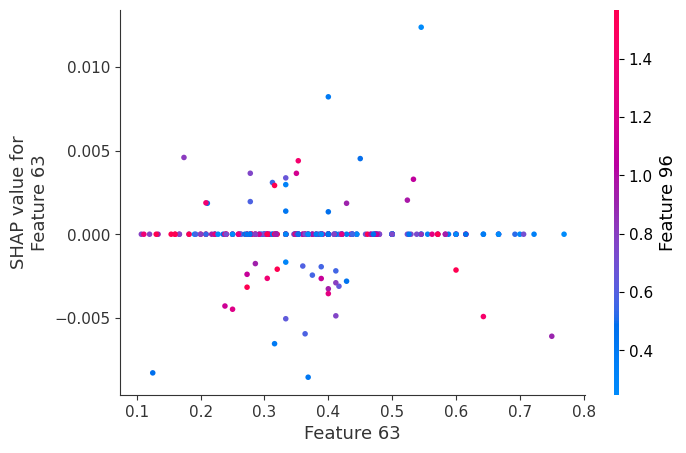

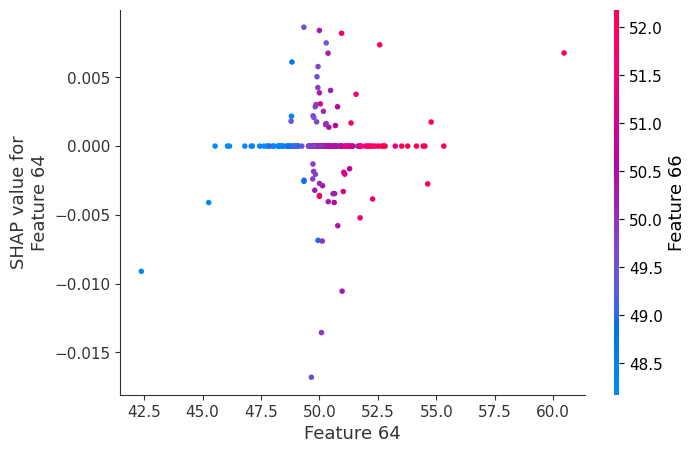

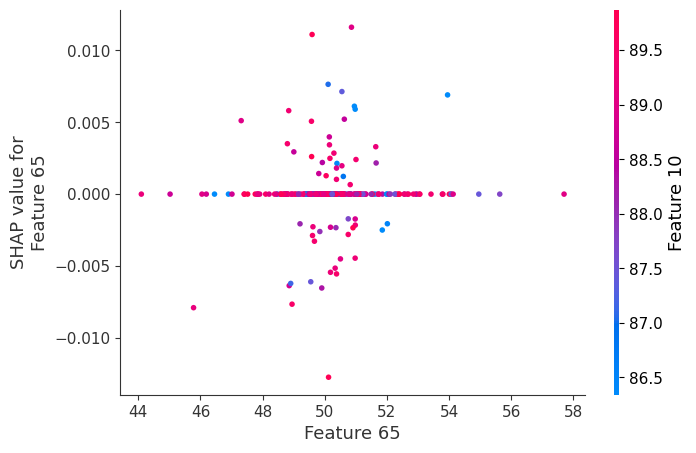

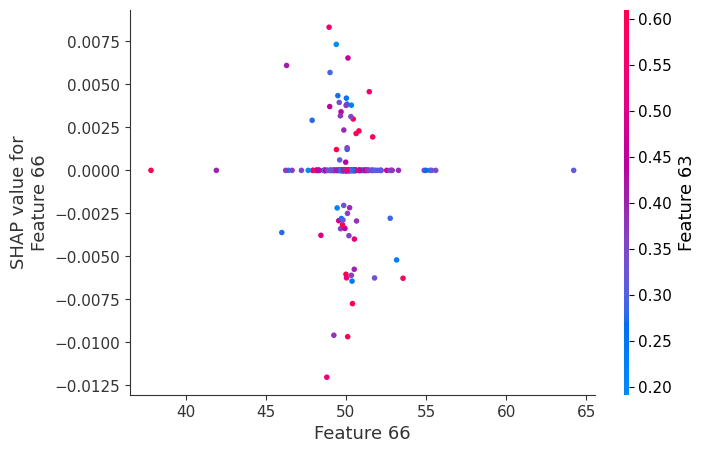

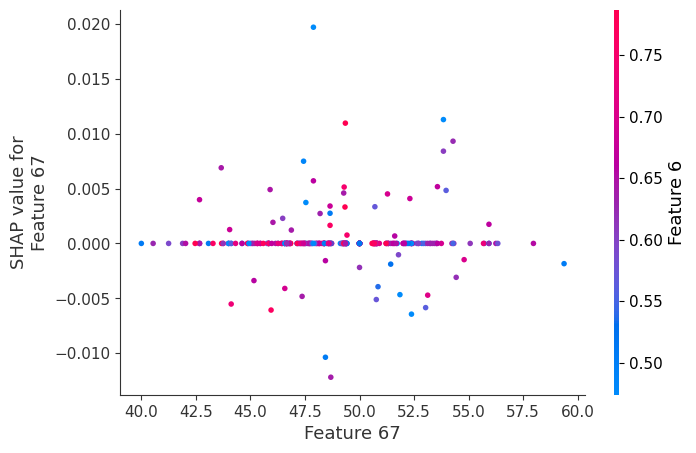

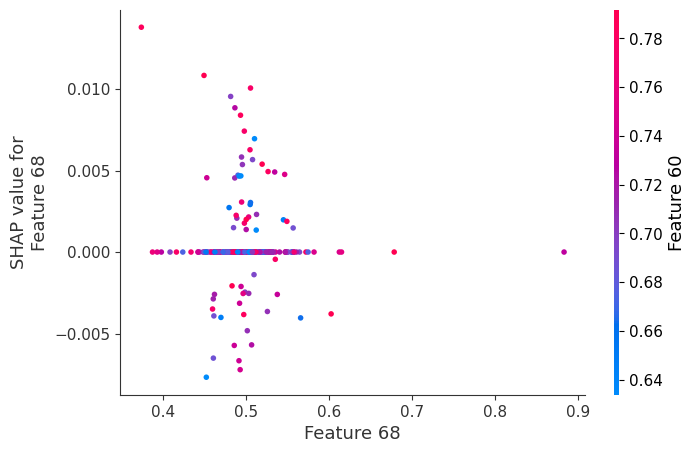

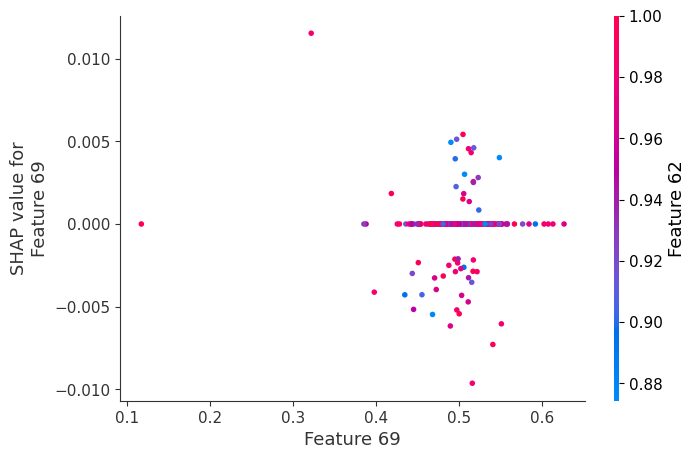

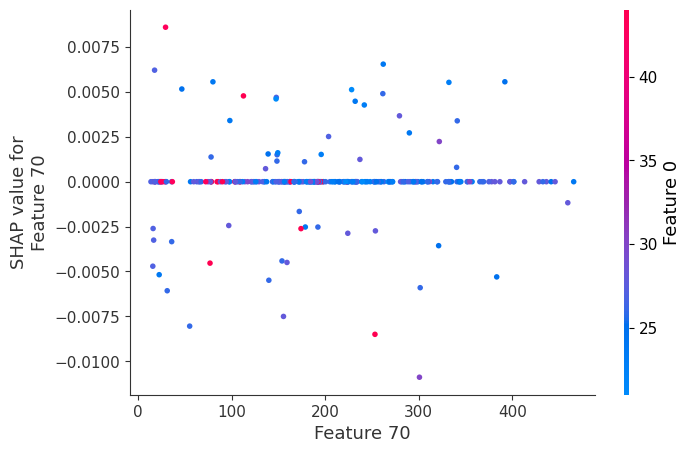

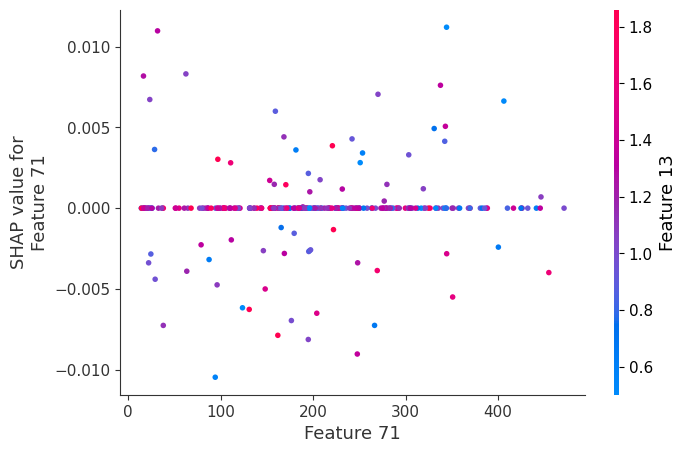

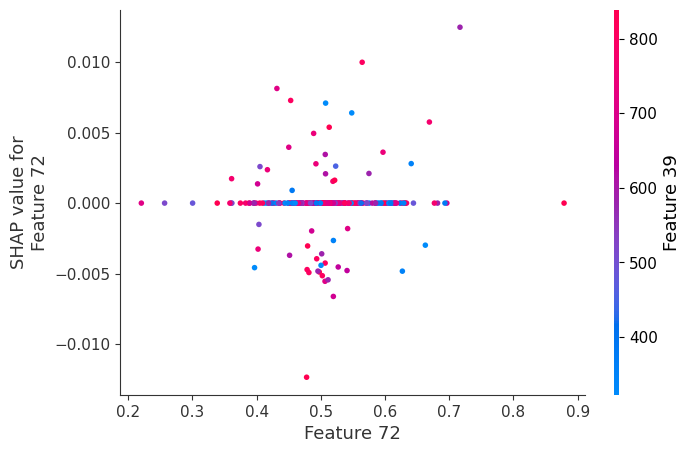

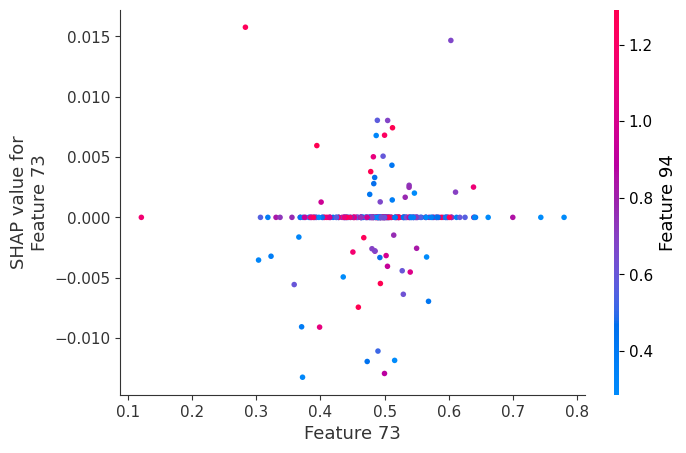

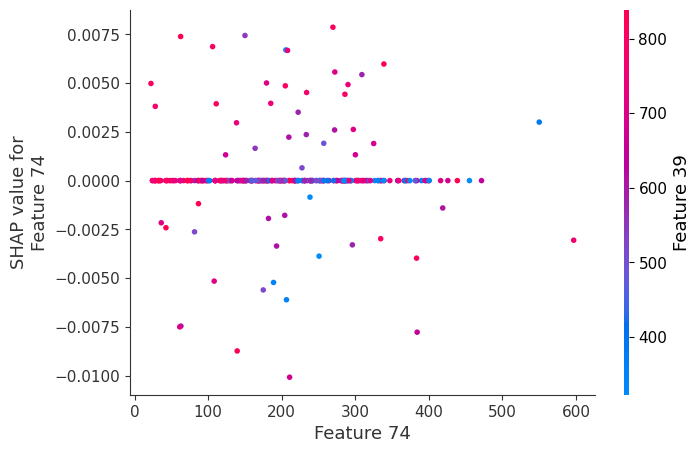

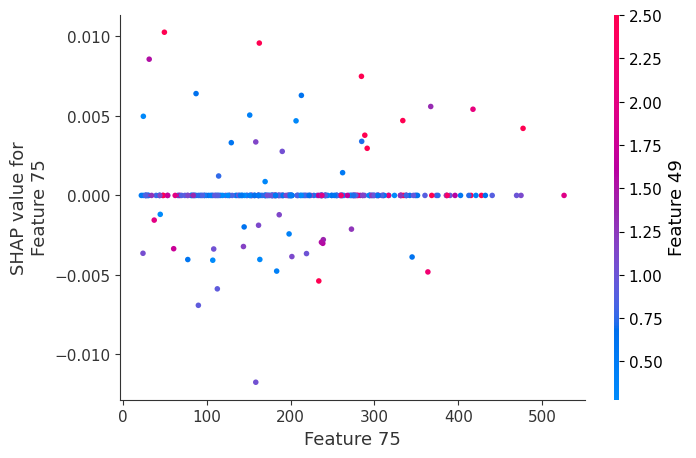

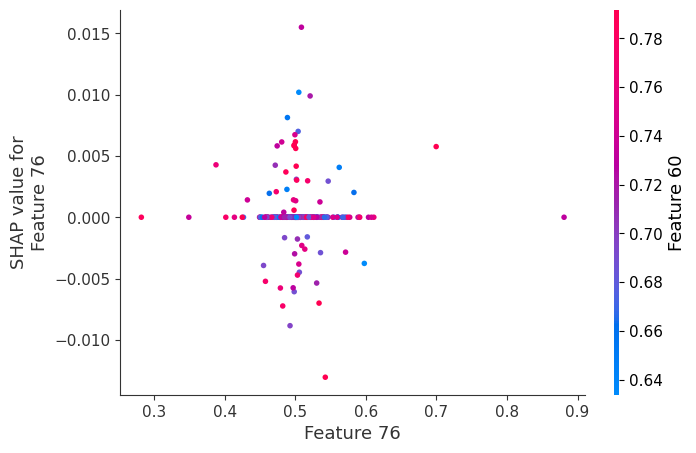

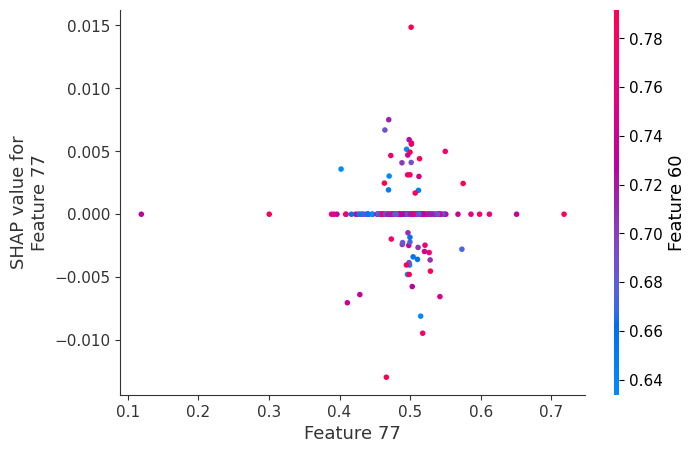

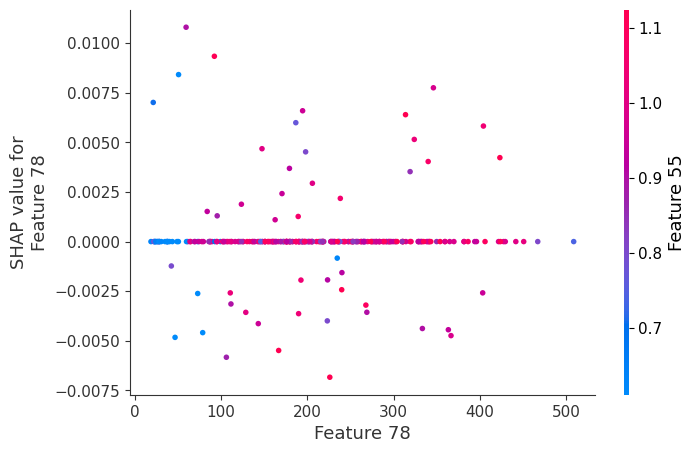

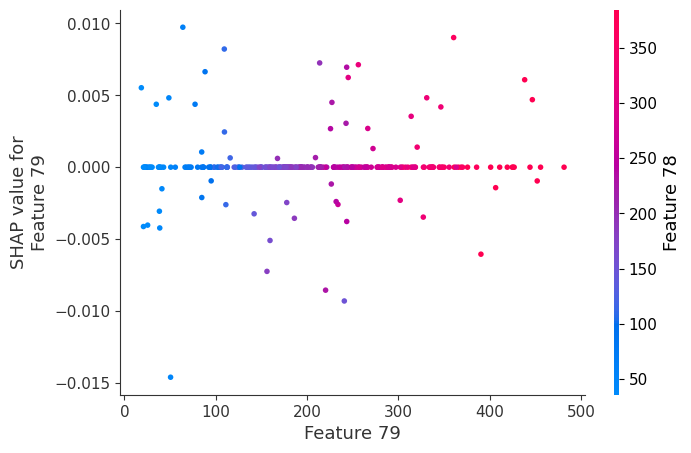

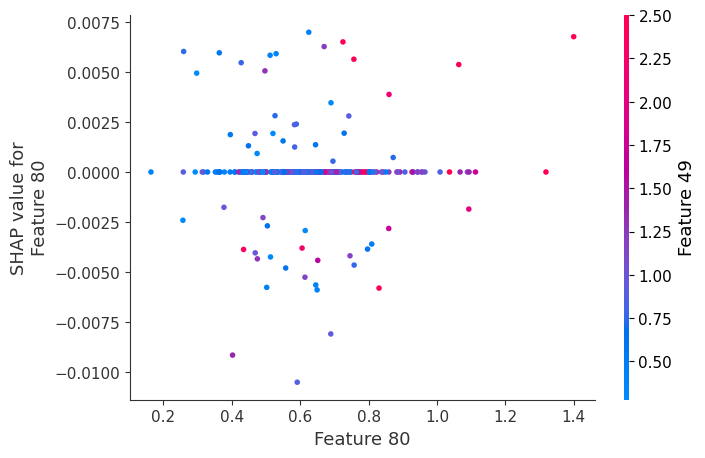

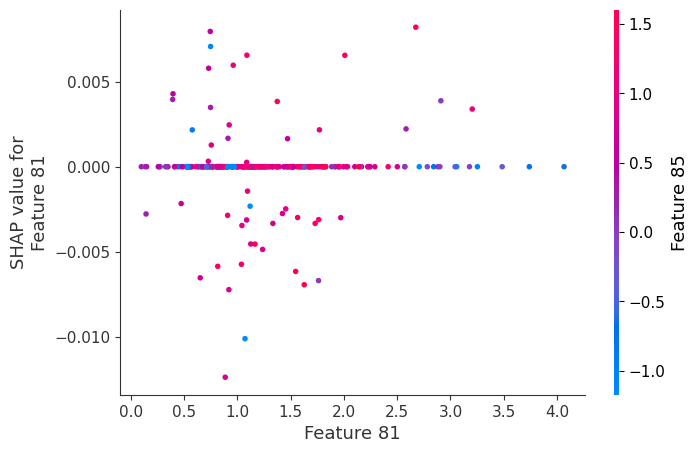

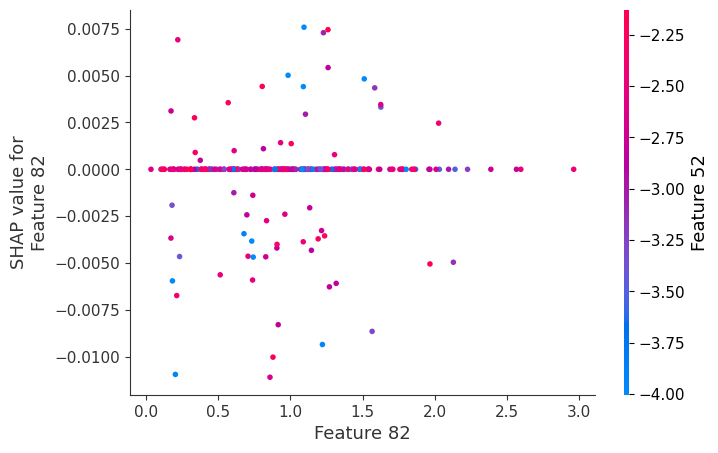

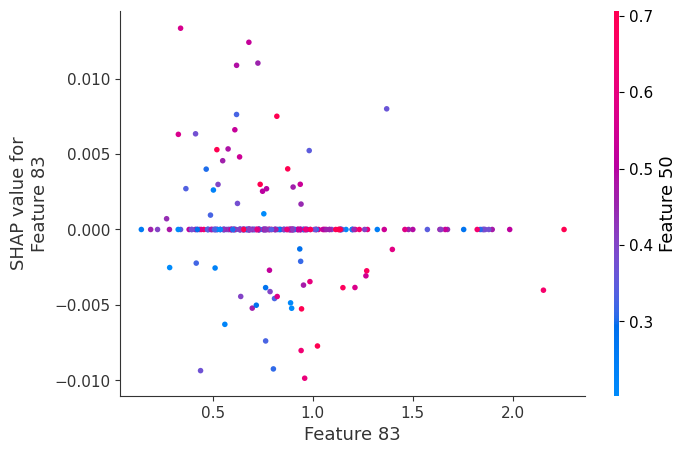

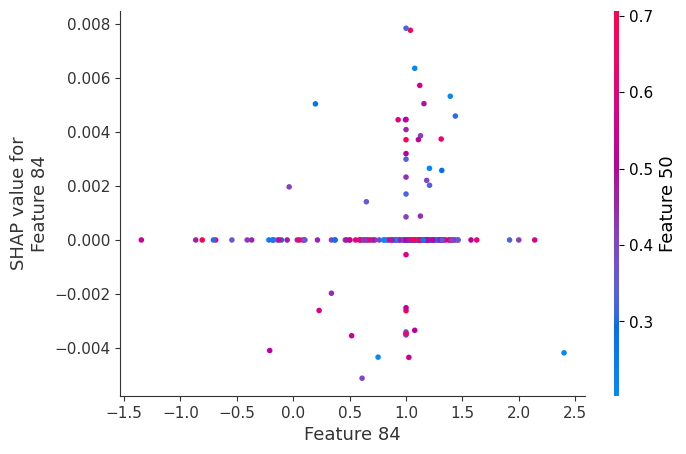

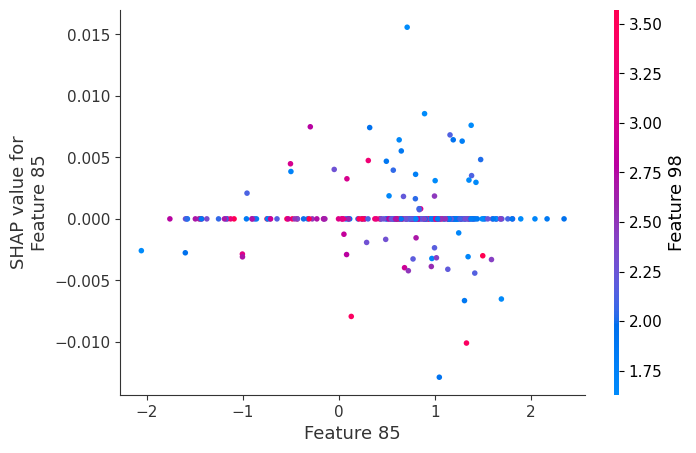

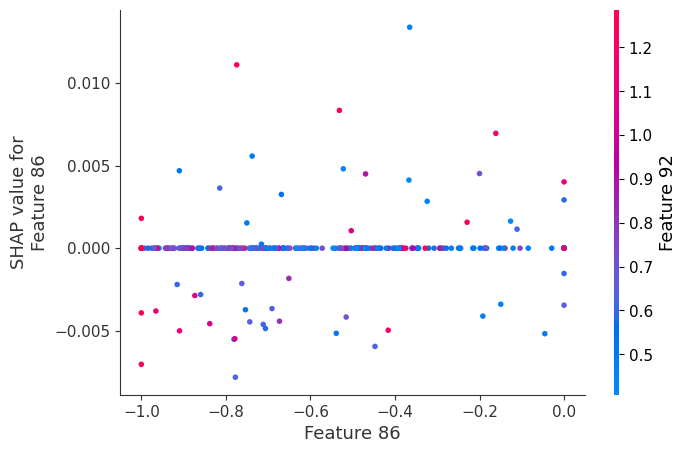

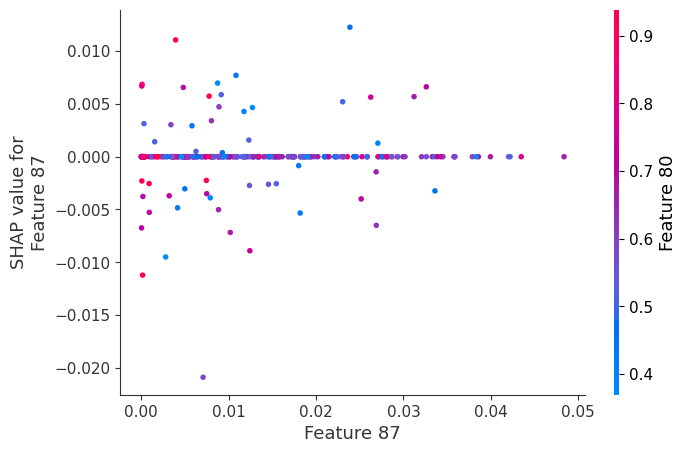

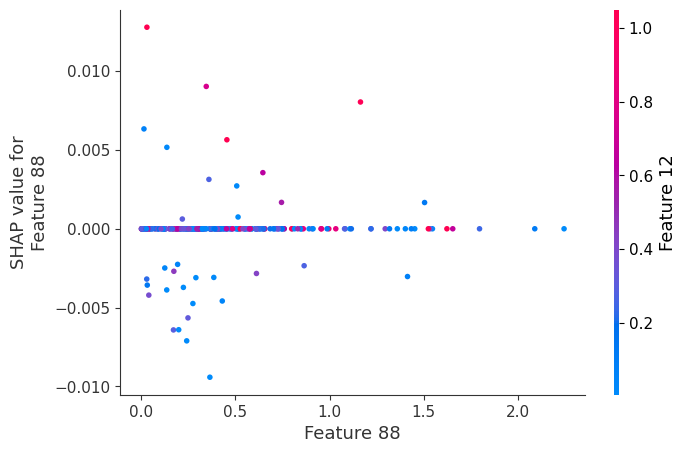

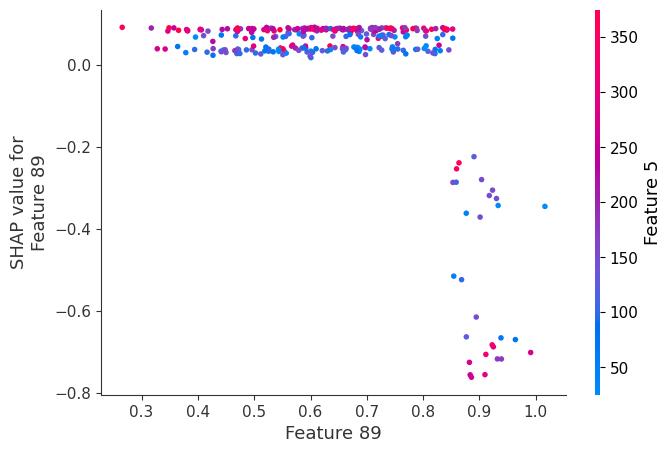

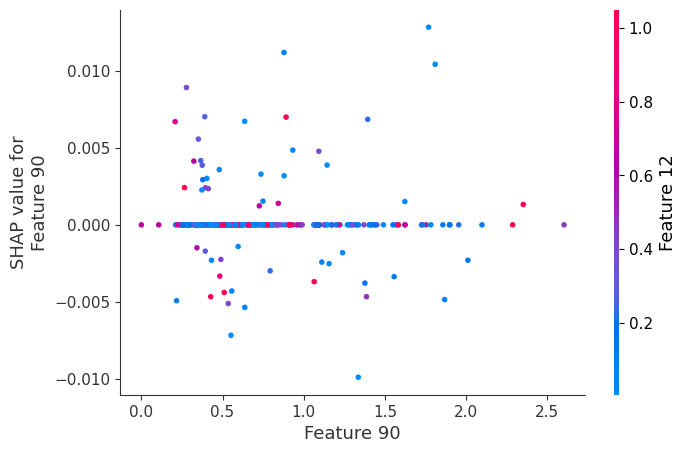

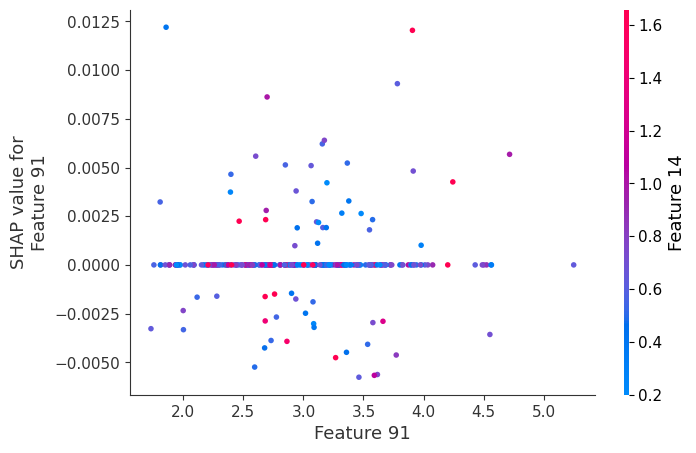

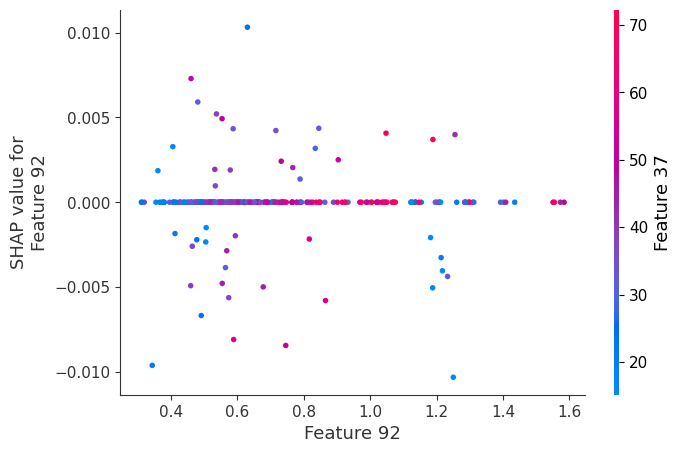

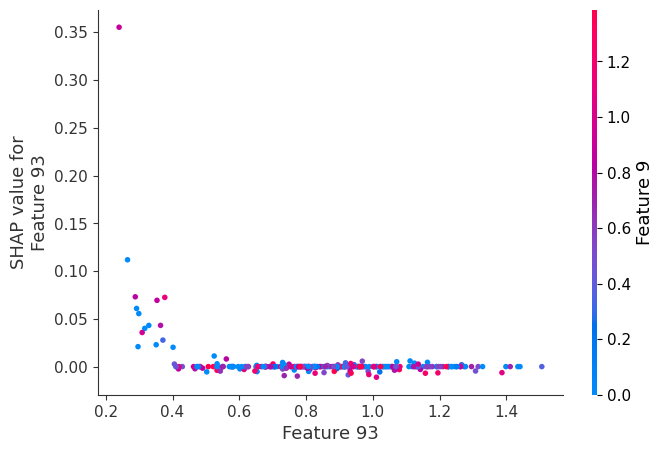

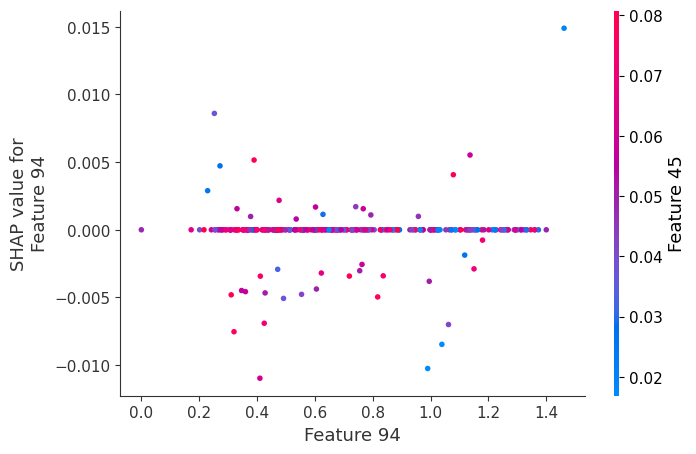

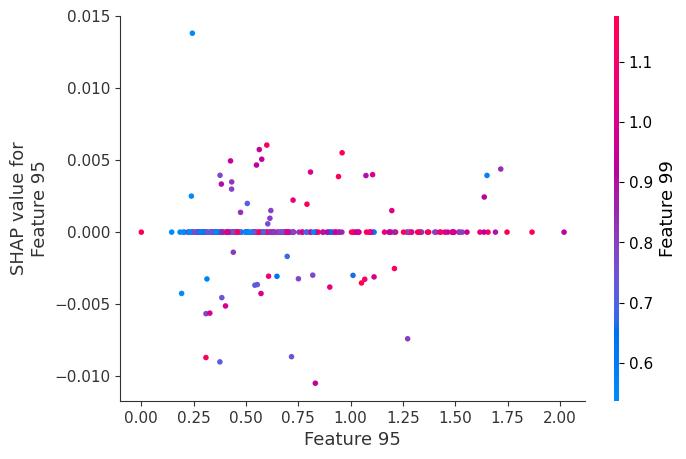

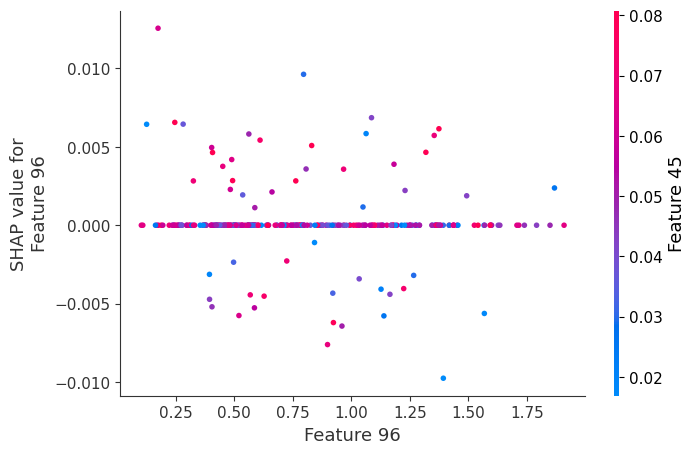

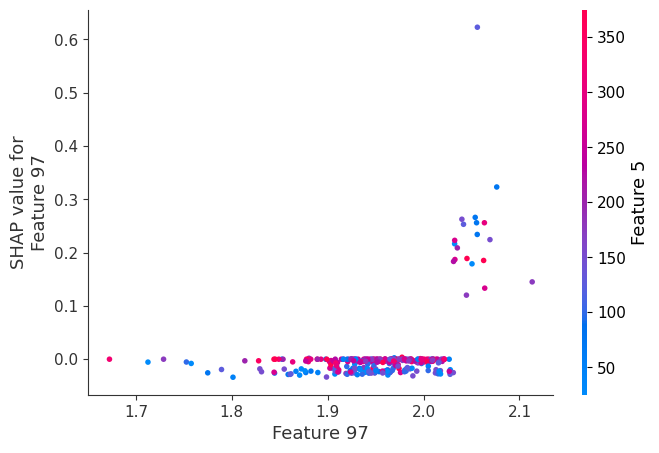

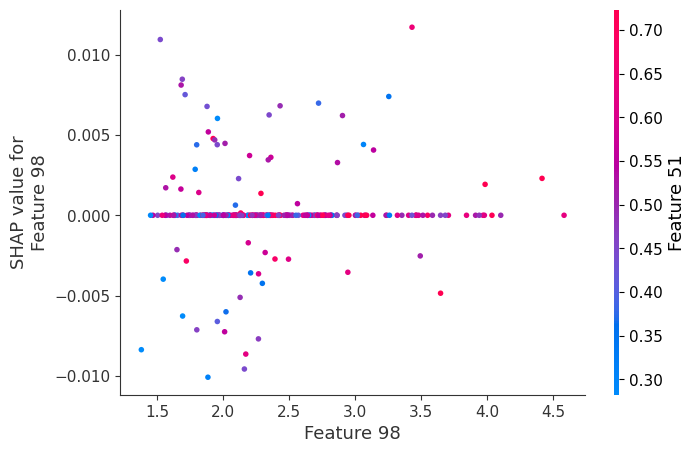

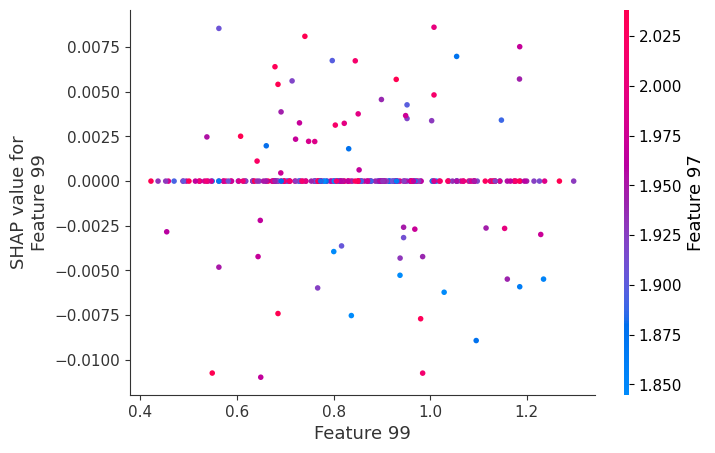

In [82]:
for i in range(len(feature_names)):
    shap.dependence_plot(i, shap_values, X)